###Importing all required Libraries

In [ ]:
# ============================================================
# 📂 Google Drive Integration
# ============================================================
# Install gdown if not already installed
%pip install gdown

# Core utilities
import os, re, glob, zipfile

# Google Drive helper
import gdown

# ============================================================
# 📊 Data Handling
# ============================================================
import pandas as pd
import numpy as np

# ============================================================
# 📈 Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Set default styles for plots
plt.style.use("seaborn-whitegrid")
sns.set_palette("Set2")

# ============================================================
# 🤖 Machine Learning
# ============================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


Loading The Data and Combinig Them

In [ ]:
# Input links
LINKS = {
    "aadhar_demographic": "https://drive.google.com/file/d/1llhHJORnBgWLpgqMn7z6renRS8g5B-Vy/view?usp=sharing",
    "aadhar_biometric": "https://drive.google.com/file/d/1XoqN6uJSBH9k0J_MOEjYZtcLnZA4KXa4/view?usp=sharing",
    "aadharenrollmet": "https://drive.google.com/uc?id=1vvonWzxOjeCM3QTkuphwmY92HTAaSVxm"
}

BASE_DIR = "aadhar_extracted"
DOWNLOAD_DIR = os.path.join(BASE_DIR, "downloads")
EXTRACT_DIR = os.path.join(BASE_DIR, "extracted")
os.makedirs(DOWNLOAD_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)

def file_id_from_url(url: str) -> str | None:
    m = re.search(r"/d/([A-Za-z0-9_-]+)", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([A-Za-z0-9_-]+)", url)
    return m.group(1) if m else None

# Download, extract each link into its own folder, then combine CSVs per link
datasets = {}  # name -> combined DataFrame for that link

for name, url in LINKS.items():
    fid = file_id_from_url(url) or url
    download_path = os.path.join(DOWNLOAD_DIR, f"{name}_{fid}.zip")
    extract_target = os.path.join(EXTRACT_DIR, name)
    os.makedirs(extract_target, exist_ok=True)

    print(f"\nDownloading '{name}' (id={fid}) to '{download_path}'...")
    # Handle cases where the URL might already be a direct download link with 'id'
    if "uc?id=" not in url and "file/d/" in url: # For view?usp=sharing links, reconstruct direct download
        gdown.download(f"https://drive.google.com/uc?id={fid}", download_path, quiet=False)
    else: # For already direct download links or unknown formats, try as is
        gdown.download(url, download_path, quiet=False)

    # Try to extract as zip; if not a zip, leave the downloaded file in place
    try:
        with zipfile.ZipFile(download_path, "r") as z:
            print(f"Extracting '{download_path}' -> '{extract_target}'...")
            z.extractall(extract_target)
    except zipfile.BadZipFile:
        print(f"Warning: '{download_path}' is not a zip file or is corrupted. Skipping extraction.")

    # Find CSVs under this link's extraction folder (recursive)
    csv_paths = sorted(glob.glob(os.path.join(extract_target, "**", "*.csv"), recursive=True))
    print(f"Found {len(csv_paths)} CSV files for '{name}'.")

    # Read and concatenate CSVs for this link
    if csv_paths:
        frames = []
        for p in csv_paths:
            try:
                print(f"  Reading {p} ...")
                frames.append(pd.read_csv(p))
            except Exception as e:
                print(f"  Skipped {p} (read error: {e})")
        combined = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    else:
        combined = pd.DataFrame()

    datasets[name] = combined

# Now you have three separate combined datasets (one per link) in the `datasets` dict.
# Display basic info for each
for name, df in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    print(f"Rows: {len(df)}  Columns: {len(df.columns)}")
    if not df.empty:
        print("First 5 rows:")
        print(df.head().to_string(index=False))
        print("\nLast 5 rows:")
        print(df.tail().to_string(index=False))
    else:
        print("Dataset is empty (no CSVs found or all reads failed).")

# Example: access individual DataFrames
# df_demographic = datasets["aadhar_demographic"]
# df_biometric   = datasets["aadhar_biometric"]
# df_enrollmet   = datasets["aadharenrollmet"]

Downloading...
From: https://drive.google.com/uc?id=1llhHJORnBgWLpgqMn7z6renRS8g5B-Vy
To: /content/aadhar_extracted/downloads/aadhar_demographic_1llhHJORnBgWLpgqMn7z6renRS8g5B-Vy.zip
100%|██████████| 13.9M/13.9M [00:00<00:00, 86.9MB/s]


Extracting 'aadhar_extracted/downloads/aadhar_demographic_1llhHJORnBgWLpgqMn7z6renRS8g5B-Vy.zip' -> 'aadhar_extracted/extracted/aadhar_demographic'...
Found 5 CSV files for 'aadhar_demographic'.
  Reading aadhar_extracted/extracted/aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv ...
  Reading aadhar_extracted/extracted/aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv ...
  Reading aadhar_extracted/extracted/aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv ...
  Reading aadhar_extracted/extracted/aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv ...
  Reading aadhar_extracted/extracted/aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv ...



Downloading...
From: https://drive.google.com/uc?id=1XoqN6uJSBH9k0J_MOEjYZtcLnZA4KXa4
To: /content/aadhar_extracted/downloads/aadhar_biometric_1XoqN6uJSBH9k0J_MOEjYZtcLnZA4KXa4.zip
100%|██████████| 13.3M/13.3M [00:00<00:00, 52.2MB/s]


Extracting 'aadhar_extracted/downloads/aadhar_biometric_1XoqN6uJSBH9k0J_MOEjYZtcLnZA4KXa4.zip' -> 'aadhar_extracted/extracted/aadhar_biometric'...
Found 4 CSV files for 'aadhar_biometric'.
  Reading aadhar_extracted/extracted/aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv ...
  Reading aadhar_extracted/extracted/aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv ...
  Reading aadhar_extracted/extracted/aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv ...
  Reading aadhar_extracted/extracted/aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv ...



Downloading...
From: https://drive.google.com/uc?id=1vvonWzxOjeCM3QTkuphwmY92HTAaSVxm
To: /content/aadhar_extracted/downloads/aadharenrollmet_1vvonWzxOjeCM3QTkuphwmY92HTAaSVxm.zip
100%|██████████| 6.86M/6.86M [00:00<00:00, 100MB/s]


Extracting 'aadhar_extracted/downloads/aadharenrollmet_1vvonWzxOjeCM3QTkuphwmY92HTAaSVxm.zip' -> 'aadhar_extracted/extracted/aadharenrollmet'...
Found 3 CSV files for 'aadharenrollmet'.
  Reading aadhar_extracted/extracted/aadharenrollmet/api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv ...
  Reading aadhar_extracted/extracted/aadharenrollmet/api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv ...
  Reading aadhar_extracted/extracted/aadharenrollmet/api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv ...

=== Dataset: aadhar_demographic ===
Rows: 2071700  Columns: 6
First 5 rows:
      date          state   district  pincode  demo_age_5_17  demo_age_17_
01-03-2025  Uttar Pradesh  Gorakhpur   273213             49           529
01-03-2025 Andhra Pradesh   Chittoor   517132             22           375
01-03-2025        Gujarat     Rajkot   360006             65           765
01-03-2025 Andhra Pradesh Srikakulam   532484             

**Preprocessing**

In [ ]:


# ==========================================
# 1. LOAD DATASETS
# ==========================================
try:
    df_enroll = datasets["aadharenrollmet"].copy()
    df_demo = datasets["aadhar_demographic"].copy()
    df_bio = datasets["aadhar_biometric"].copy()
    print("✅ Datasets loaded successfully.\n")
except NameError:
    print("❌ Error: 'datasets' dictionary not found. Please load your CSVs first.")

# ==========================================
# 2. THE PREPROCESSING ENGINE (Function)
# ==========================================
def preprocess_and_audit(df, name):
    print(f"--- AUDITING: {name} ---")
    issues_found = False

    # A. Standardize Column Names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

    # B. Date Parsing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        invalid_dates = df['date'].isnull().sum()
        if invalid_dates > 0:
            print(f"⚠️ Found {invalid_dates} invalid dates. Dropping them...")
            df.dropna(subset=['date'], inplace=True)
            issues_found = True

    # C. Missing Values
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"⚠️ Found {missing_count} missing values.")
        display(df.isnull().sum()[df.isnull().sum() > 0])
        num_cols = df.select_dtypes(include=[np.number]).columns
        cat_cols = df.select_dtypes(include=['object']).columns
        df[num_cols] = df[num_cols].fillna(0)
        df[cat_cols] = df[cat_cols].fillna('Unknown')
        print("   -> 🔧 Fixed: Filled missing numeric with 0 and text with 'Unknown'.")
        issues_found = True

    # D. Negative Numbers
    num_cols = df.select_dtypes(include=[np.number]).columns
    negative_values = (df[num_cols] < 0).sum().sum()
    if negative_values > 0:
        print(f"⚠️ Found {negative_values} negative numbers. Converting to absolute values...")
        df[num_cols] = df[num_cols].abs()
        issues_found = True

    # E. Duplicate Check
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"⚠️ Found {duplicates} duplicate rows. Removing them...")
        df.drop_duplicates(inplace=True)
        issues_found = True

    # F. Outlier Detection (IQR method, top 10 flagged)
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            print(f"⚠️ Column '{col}' has {len(outliers)} potential outliers.")
            print("   -> Showing top 10 outliers with reason:")
            display(outliers[[col]].head(10))
            print(f"   Reason: Values outside [{lower_bound:.2f}, {upper_bound:.2f}] range (IQR rule).")
            issues_found = True

    # G. Inconsistent Categorical Values
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].str.strip().str.lower()

    # H. Constant Columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print(f"⚠️ Found constant columns: {constant_cols}. Dropping them...")
        df.drop(columns=constant_cols, inplace=True)
        issues_found = True

    # I. Final Status
    if not issues_found:
        print("✅ Status: CLEAN. No major issues found.")
    else:
        print("✅ Status: CLEANED. Issues resolved or flagged.")
    print("-" * 30)
    return df

# ==========================================
# 3. EXECUTE PREPROCESSING (Overwrite originals)
# ==========================================
df_enroll = preprocess_and_audit(df_enroll, "Aadhaar Enrollment Data")
df_demo   = preprocess_and_audit(df_demo, "Demographic Update Data")
df_bio    = preprocess_and_audit(df_bio, "Biometric Update Data")

# ==========================================
# 4. FINAL SNAPSHOT
# ==========================================
print("\n=== FINAL DATA SNAPSHOT ===")
print(f"Enrollment Rows: {len(df_enroll)}")
print(f"Demographic Rows: {len(df_demo)}")
print(f"Biometric Rows:   {len(df_bio)}")


✅ Datasets loaded successfully.

--- AUDITING: Aadhaar Enrollment Data ---
⚠️ Found 22957 duplicate rows. Removing them...
⚠️ Column 'age_0_5' has 99397 potential outliers.
   -> Showing top 10 outliers with reason:


,age_0_5
0,11
1,14
2,29
3,62
4,14
5,20
6,23
7,26
8,28
9,30


   Reason: Values outside [-2.00, 6.00] range (IQR rule).
⚠️ Column 'age_5_17' has 132460 potential outliers.
   -> Showing top 10 outliers with reason:


,age_5_17
0,61
1,33
2,82
3,29
4,16
5,49
6,24
7,60
8,26
9,48


   Reason: Values outside [-1.50, 2.50] range (IQR rule).
⚠️ Column 'age_18_greater' has 39254 potential outliers.
   -> Showing top 10 outliers with reason:


,age_18_greater
0,37
1,39
2,12
3,15
4,21
5,12
6,42
7,14
8,10
9,10


   Reason: Values outside [0.00, 0.00] range (IQR rule).
✅ Status: CLEANED. Issues resolved or flagged.
------------------------------
--- AUDITING: Demographic Update Data ---
⚠️ Found 473601 duplicate rows. Removing them...
⚠️ Column 'demo_age_5_17' has 112740 potential outliers.
   -> Showing top 10 outliers with reason:


,demo_age_5_17
0,49
1,22
2,65
3,24
4,45
5,28
6,88
7,61
8,83
9,13


   Reason: Values outside [-3.00, 5.00] range (IQR rule).
⚠️ Column 'demo_age_17_' has 165751 potential outliers.
   -> Showing top 10 outliers with reason:


,demo_age_17_
0,529
1,375
2,765
3,314
4,785
5,285
6,332
7,836
8,986
9,281


   Reason: Values outside [-17.50, 34.50] range (IQR rule).
✅ Status: CLEANED. Issues resolved or flagged.
------------------------------
--- AUDITING: Biometric Update Data ---
⚠️ Found 94896 duplicate rows. Removing them...
⚠️ Column 'bio_age_5_17' has 201325 potential outliers.
   -> Showing top 10 outliers with reason:


,bio_age_5_17
0,280
1,144
2,643
3,256
4,271
5,155
6,75
7,192
8,122
9,67


   Reason: Values outside [-14.00, 26.00] range (IQR rule).
⚠️ Column 'bio_age_17_' has 210205 potential outliers.
   -> Showing top 10 outliers with reason:


,bio_age_17_
0,577
1,369
2,1091
3,980
4,815
5,529
6,143
7,298
8,214
9,85


   Reason: Values outside [-12.50, 23.50] range (IQR rule).
✅ Status: CLEANED. Issues resolved or flagged.
------------------------------

=== FINAL DATA SNAPSHOT ===
Enrollment Rows: 983072
Demographic Rows: 1598099
Biometric Rows:   1766212


In [ ]:
# ==========================================
# 1. LOAD DATASETS
# ==========================================
try:
    df_enroll = datasets["aadharenrollmet"].copy()
    df_demo = datasets["aadhar_demographic"].copy()
    df_bio = datasets["aadhar_biometric"].copy()
    print("✅ Datasets loaded successfully.\n")
except NameError:
    print("❌ Error: 'datasets' dictionary not found. Please load your CSVs first.")

# ==========================================
# 2. THE PREPROCESSING ENGINE (Function)
# ==========================================
def preprocess_and_audit(df, name):
    print(f"--- AUDITING: {name} ---")
    issues_found = False

    # A. Standardize Column Names (Remove spaces, lowercase)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

    # B. Date Parsing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        invalid_dates = df['date'].isnull().sum()
        if invalid_dates > 0:
            print(f"⚠️ Found {invalid_dates} invalid dates. Dropping them...")
            df.dropna(subset=['date'], inplace=True)
            issues_found = True

    # C. Missing Values Check
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"⚠️ Found {missing_count} missing values.")
        display(df.isnull().sum()[df.isnull().sum() > 0])
        num_cols = df.select_dtypes(include=[np.number]).columns
        cat_cols = df.select_dtypes(include=['object']).columns
        df[num_cols] = df[num_cols].fillna(0)
        df[cat_cols] = df[cat_cols].fillna('Unknown')
        print("   -> 🔧 Fixed: Filled missing numeric with 0 and text with 'Unknown'.")
        issues_found = True

    # D. Noise / Logic Check (Negative Numbers)
    num_cols = df.select_dtypes(include=[np.number]).columns
    negative_values = (df[num_cols] < 0).sum().sum()
    if negative_values > 0:
        print(f"⚠️ Found {negative_values} negative numbers. Converting to absolute values...")
        df[num_cols] = df[num_cols].abs()
        issues_found = True

    # E. Duplicate Check
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"⚠️ Found {duplicates} duplicate rows. Removing them...")
        df.drop_duplicates(inplace=True)
        issues_found = True

    # F. Outlier Detection (basic IQR method)
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        if outliers > 0:
            print(f"⚠️ Column '{col}' has {outliers} potential outliers. (Flagged, not dropped)")
            # ⚠️ We only flag outliers here, not remove them to avoid excess cleaning.

    # G. Inconsistent Categorical Values (case normalization)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].str.strip().str.lower()

    # H. Data Type Validation
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='ignore')
            except:
                pass  # keep as text if conversion fails

    # I. Constant Columns (low variance check)
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print(f"⚠️ Found constant columns: {constant_cols}. Dropping them...")
        df.drop(columns=constant_cols, inplace=True)
        issues_found = True

    # J. Final Status
    if not issues_found:
        print("✅ Status: CLEAN. No major issues found.")
    else:
        print("✅ Status: CLEANED. Issues resolved or flagged.")
    print("-" * 30)
    return df

# ==========================================
# 3. EXECUTE PREPROCESSING
# ==========================================
clean_enroll = preprocess_and_audit(df_enroll, "Aadhaar Enrollment Data")
clean_demo = preprocess_and_audit(df_demo, "Demographic Update Data")
clean_bio = preprocess_and_audit(df_bio, "Biometric Update Data")

# ==========================================
# 4. FINAL VERIFICATION DISPLAY
# ==========================================
print("\n=== FINAL DATA SNAPSHOT ===")
print(f"Enrollment Rows: {len(clean_enroll)}")
print(f"Demographic Rows: {len(clean_demo)}")
print(f"Biometric Rows:   {len(clean_bio)}")


✅ Datasets loaded successfully.

--- AUDITING: Aadhaar Enrollment Data ---
⚠️ Found 22957 duplicate rows. Removing them...
⚠️ Column 'age_0_5' has 99397 potential outliers. (Flagged, not dropped)
⚠️ Column 'age_5_17' has 132460 potential outliers. (Flagged, not dropped)
⚠️ Column 'age_18_greater' has 39254 potential outliers. (Flagged, not dropped)


/tmp/ipython-input-2695057187.py:77: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


✅ Status: CLEANED. Issues resolved or flagged.
------------------------------
--- AUDITING: Demographic Update Data ---
⚠️ Found 473601 duplicate rows. Removing them...
⚠️ Column 'demo_age_5_17' has 112740 potential outliers. (Flagged, not dropped)
⚠️ Column 'demo_age_17_' has 165751 potential outliers. (Flagged, not dropped)


/tmp/ipython-input-2695057187.py:77: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


✅ Status: CLEANED. Issues resolved or flagged.
------------------------------
--- AUDITING: Biometric Update Data ---
⚠️ Found 94896 duplicate rows. Removing them...
⚠️ Column 'bio_age_5_17' has 201325 potential outliers. (Flagged, not dropped)
⚠️ Column 'bio_age_17_' has 210205 potential outliers. (Flagged, not dropped)


/tmp/ipython-input-2695057187.py:77: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


✅ Status: CLEANED. Issues resolved or flagged.
------------------------------

=== FINAL DATA SNAPSHOT ===
Enrollment Rows: 983072
Demographic Rows: 1598099
Biometric Rows:   1766212


In [ ]:
# ==========================================
# 1. LOAD DATASETS
# ==========================================
try:
    df_enroll = datasets["aadharenrollmet"].copy()
    df_demo = datasets["aadhar_demographic"].copy()
    df_bio = datasets["aadhar_biometric"].copy()
    print("✅ Datasets loaded successfully.\n")
except NameError:
    print("❌ Error: 'datasets' dictionary not found. Please load your CSVs first.")

# ==========================================
# 2. THE PREPROCESSING ENGINE (Function)
# ==========================================
def preprocess_and_audit(df, name):
    print(f"--- AUDITING: {name} ---")
    issues_found = False

    # A. Standardize Column Names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

    # B. Date Parsing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        invalid_dates = df['date'].isnull().sum()
        if invalid_dates > 0:
            print(f"⚠️ Found {invalid_dates} invalid dates. Dropping them...")
            df.dropna(subset=['date'], inplace=True)
            issues_found = True

    # C. Missing Values
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"⚠️ Found {missing_count} missing values.")
        display(df.isnull().sum()[df.isnull().sum() > 0])
        num_cols = df.select_dtypes(include=[np.number]).columns
        cat_cols = df.select_dtypes(include=['object']).columns
        df[num_cols] = df[num_cols].fillna(0)
        df[cat_cols] = df[cat_cols].fillna('Unknown')
        print("   -> 🔧 Fixed: Filled missing numeric with 0 and text with 'Unknown'.")
        issues_found = True

    # D. Negative Numbers
    num_cols = df.select_dtypes(include=[np.number]).columns
    negative_values = (df[num_cols] < 0).sum().sum()
    if negative_values > 0:
        print(f"⚠️ Found {negative_values} negative numbers. Converting to absolute values...")
        df[num_cols] = df[num_cols].abs()
        issues_found = True

    # E. Duplicate Check
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"⚠️ Found {duplicates} duplicate rows. Removing them...")
        df.drop_duplicates(inplace=True)
        issues_found = True

    # F. Outlier Detection (IQR method, top 10 flagged)
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            print(f"⚠️ Column '{col}' has {len(outliers)} potential outliers.")
            print("   -> Showing top 10 outliers with reason:")
            display(outliers[[col]].head(10))
            print(f"   Reason: Values outside [{lower_bound:.2f}, {upper_bound:.2f}] range (IQR rule).")
            issues_found = True

    # G. Inconsistent Categorical Values
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].str.strip().str.lower()

    # H. Constant Columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print(f"⚠️ Found constant columns: {constant_cols}. Dropping them...")
        df.drop(columns=constant_cols, inplace=True)
        issues_found = True

    # I. Final Status
    if not issues_found:
        print("✅ Status: CLEAN. No major issues found.")
    else:
        print("✅ Status: CLEANED. Issues resolved or flagged.")
    print("-" * 30)
    return df

# ==========================================
# 3. EXECUTE PREPROCESSING (Overwrite originals)
# ==========================================
df_enroll = preprocess_and_audit(df_enroll, "Aadhaar Enrollment Data")
df_demo   = preprocess_and_audit(df_demo, "Demographic Update Data")
df_bio    = preprocess_and_audit(df_bio, "Biometric Update Data")

# ==========================================
# 4. FINAL SNAPSHOT
# ==========================================
print("\n=== FINAL DATA SNAPSHOT ===")
print(f"Enrollment Rows: {len(df_enroll)}")
print(f"Demographic Rows: {len(df_demo)}")
print(f"Biometric Rows:   {len(df_bio)}")


✅ Datasets loaded successfully.

--- AUDITING: Aadhaar Enrollment Data ---
⚠️ Found 22957 duplicate rows. Removing them...
⚠️ Column 'age_0_5' has 99397 potential outliers.
   -> Showing top 10 outliers with reason:


,age_0_5
0,11
1,14
2,29
3,62
4,14
5,20
6,23
7,26
8,28
9,30


   Reason: Values outside [-2.00, 6.00] range (IQR rule).
⚠️ Column 'age_5_17' has 132460 potential outliers.
   -> Showing top 10 outliers with reason:


,age_5_17
0,61
1,33
2,82
3,29
4,16
5,49
6,24
7,60
8,26
9,48


   Reason: Values outside [-1.50, 2.50] range (IQR rule).
⚠️ Column 'age_18_greater' has 39254 potential outliers.
   -> Showing top 10 outliers with reason:


,age_18_greater
0,37
1,39
2,12
3,15
4,21
5,12
6,42
7,14
8,10
9,10


   Reason: Values outside [0.00, 0.00] range (IQR rule).
✅ Status: CLEANED. Issues resolved or flagged.
------------------------------
--- AUDITING: Demographic Update Data ---
⚠️ Found 473601 duplicate rows. Removing them...
⚠️ Column 'demo_age_5_17' has 112740 potential outliers.
   -> Showing top 10 outliers with reason:


,demo_age_5_17
0,49
1,22
2,65
3,24
4,45
5,28
6,88
7,61
8,83
9,13


   Reason: Values outside [-3.00, 5.00] range (IQR rule).
⚠️ Column 'demo_age_17_' has 165751 potential outliers.
   -> Showing top 10 outliers with reason:


,demo_age_17_
0,529
1,375
2,765
3,314
4,785
5,285
6,332
7,836
8,986
9,281


   Reason: Values outside [-17.50, 34.50] range (IQR rule).
✅ Status: CLEANED. Issues resolved or flagged.
------------------------------
--- AUDITING: Biometric Update Data ---
⚠️ Found 94896 duplicate rows. Removing them...
⚠️ Column 'bio_age_5_17' has 201325 potential outliers.
   -> Showing top 10 outliers with reason:


,bio_age_5_17
0,280
1,144
2,643
3,256
4,271
5,155
6,75
7,192
8,122
9,67


   Reason: Values outside [-14.00, 26.00] range (IQR rule).
⚠️ Column 'bio_age_17_' has 210205 potential outliers.
   -> Showing top 10 outliers with reason:


,bio_age_17_
0,577
1,369
2,1091
3,980
4,815
5,529
6,143
7,298
8,214
9,85


   Reason: Values outside [-12.50, 23.50] range (IQR rule).
✅ Status: CLEANED. Issues resolved or flagged.
------------------------------

=== FINAL DATA SNAPSHOT ===
Enrollment Rows: 983072
Demographic Rows: 1598099
Biometric Rows:   1766212


In [ ]:
# Load dataset
df_enrollment = datasets["aadharenrollmet"]

# Create a cleaned copy
df_enrollment_cleaned = df_enrollment.copy()

# --- Enrollment totals by age group ---
total_enrollments = {
    "age_0_5": df_enrollment_cleaned['age_0_5'].sum(),
    "age_5_17": df_enrollment_cleaned['age_5_17'].sum(),
    "age_18_greater": df_enrollment_cleaned['age_18_greater'].sum()
}

print("Total new enrollments by age group:")
for age_group, total in total_enrollments.items():
    print(f"{age_group.replace('_', ' ')}: {total}")

# --- Overall total across all age groups ---
total_new_enrollments = sum(total_enrollments.values())
print(f"\nTotal new enrollments across all age groups: {total_new_enrollments}")

# --- Date range (first and last date) ---
df_enrollment_cleaned['date_parsed'] = pd.to_datetime(df_enrollment_cleaned['date'], format='%d-%m-%Y')
first_date = df_enrollment_cleaned['date_parsed'].min().strftime('%d-%m-%Y')
last_date = df_enrollment_cleaned['date_parsed'].max().strftime('%d-%m-%Y')

print(f"\nFirst date in the dataset: {first_date}")
print(f"Last date in the dataset: {last_date}")

# --- State-wise enrollments for age 0-5 ---
enrollment_0_5_by_state = (
    df_enrollment_cleaned.groupby('state')['age_0_5']
    .sum()
    .reset_index()
    .rename(columns={'age_0_5': 'total_age_0_5_enrollments'})
)

print("\nTotal Aadhar enrollments for ages 0-5 by State (all years):")
display(enrollment_0_5_by_state)


Total new enrollments by age group:
age 0 5: 3546965
age 5 17: 1720384
age 18 greater: 168353

Total new enrollments across all age groups: 5435702

First date in the dataset: 02-03-2025
Last date in the dataset: 31-12-2025

Total Aadhar enrollments for ages 0-5 by State (all years):


,state,total_age_0_5_enrollments
0,100000,0
1,Andaman & Nicobar Islands,109
2,Andaman and Nicobar Islands,370
3,Andhra Pradesh,112440
4,Arunachal Pradesh,1957
5,Assam,141235
6,Bihar,262875
7,Chandigarh,2476
8,Chhattisgarh,82453
9,Dadra & Nagar Haveli,22


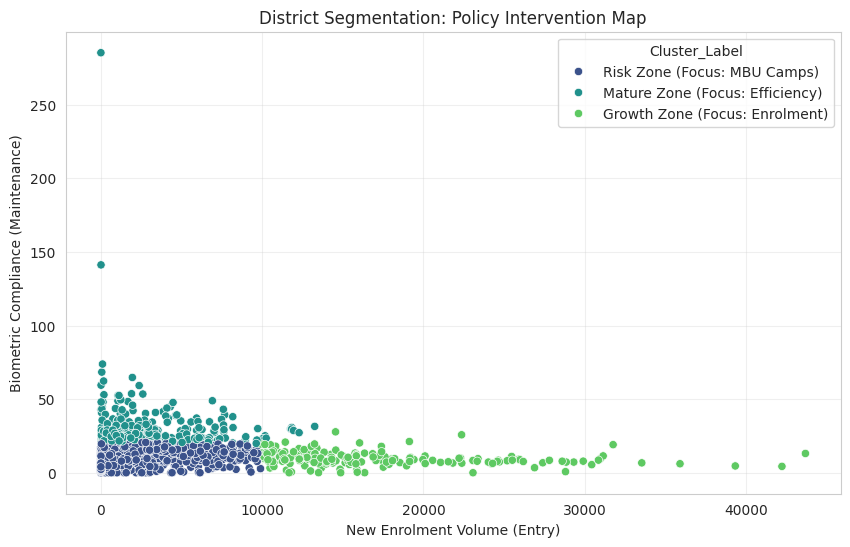

=== CRITICAL ACTION REPORT ===

Top 5 States needing School Biometric Camps (Risk Zone):
state
Karnataka         52
Uttar Pradesh     44
West Bengal       40
Madhya Pradesh    37
Orissa            34
Name: count, dtype: int64

=== CLUSTER PROFILES (Average Values) ===
                                 total_enroll  bio_compliance
Cluster_Label                                                
Growth Zone (Focus: Enrolment)   17178.808140        9.587662
Mature Zone (Focus: Efficiency)   3180.174603       31.704909
Risk Zone (Focus: MBU Camps)      2599.911765        9.421300


In [ ]:
# 1. Access DataFrames from your dictionary
df_demo = datasets["aadhar_demographic"]
df_bio = datasets["aadhar_biometric"]
df_enroll = datasets["aadharenrollmet"]

# 2. Data Aggregation (Creating the "District Profile")
# We sum the data by District/State to get a holistic view
# ---------------------------------------------------------

# Aggregate Enrolment: Focus on Total Volume
df_enroll['total_enroll'] = df_enroll['age_0_5'] + df_enroll['age_5_17'] + df_enroll['age_18_greater']
grp_enroll = df_enroll.groupby(['state', 'district'])['total_enroll'].sum().reset_index()

# Aggregate Biometric: Focus on Child Compliance (Age 5-17 is critical)
df_bio['total_bio'] = df_bio['bio_age_5_17'] + df_bio['bio_age_17_']
grp_bio = df_bio.groupby(['state', 'district'])['total_bio'].sum().reset_index()

# Aggregate Demographic: Focus on Corrections
df_demo['total_demo'] = df_demo['demo_age_5_17'] + df_demo['demo_age_17_']
grp_demo = df_demo.groupby(['state', 'district'])['total_demo'].sum().reset_index()

# Merge all three into a single Master DataFrame
df_master = grp_enroll.merge(grp_demo, on=['state', 'district'], how='left') \
                      .merge(grp_bio, on=['state', 'district'], how='left')
df_master.fillna(0, inplace=True)

# 3. Feature Engineering for the Model
# -------------------------------------
# Raw numbers are biased by population size. We use Ratios for better logic.

# Metric 1: Bio Compliance Ratio (Updates per Enrolment)
# High Ratio = Mature Ecosystem (Maintenance Phase)
# Low Ratio = Growth Ecosystem (Entry Phase) or Risk (Lagging)
df_master['bio_compliance'] = df_master['total_bio'] / (df_master['total_enroll'] + 1)

# Metric 2: Correction Intensity
df_master['correction_intensity'] = df_master['total_demo'] / (df_master['total_enroll'] + 1)

# 4. K-Means Clustering Model
# ---------------------------
features = ['total_enroll', 'bio_compliance']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_master[features])

# We use 3 Clusters: Growth, Mature, Risk
kmeans = KMeans(n_clusters=3, random_state=42)
df_master['Cluster_ID'] = kmeans.fit_predict(X_scaled)

# 5. Smart Labeling (Auto-detecting the Zones)
# --------------------------------------------
# We analyze the cluster centers to name them human-readably
cluster_means = df_master.groupby('Cluster_ID')[features].mean()

# "Growth Zone" has the Highest Enrollment
growth_id = cluster_means['total_enroll'].idxmax()

# "Mature Zone" has the Highest Bio Compliance
mature_id = cluster_means['bio_compliance'].idxmax()

# "Risk Zone" is the remaining one (Low Enroll, Low Compliance)
risk_id = list(set(cluster_means.index) - {growth_id, mature_id})[0]

label_map = {
    growth_id: 'Growth Zone (Focus: Enrolment)',
    mature_id: 'Mature Zone (Focus: Efficiency)',
    risk_id:   'Risk Zone (Focus: MBU Camps)'
}
df_master['Cluster_Label'] = df_master['Cluster_ID'].map(label_map)

# 6. Visualization & Reporting
# ----------------------------

# Plot 1: Scatter Plot of Districts
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_master, x='total_enroll', y='bio_compliance', hue='Cluster_Label', palette='viridis')
plt.title('District Segmentation: Policy Intervention Map')
plt.xlabel('New Enrolment Volume (Entry)')
plt.ylabel('Biometric Compliance (Maintenance)')
plt.grid(True, alpha=0.3)
plt.show()

# Report: Top States in "Risk Zone"
print("=== CRITICAL ACTION REPORT ===")
risk_districts = df_master[df_master['Cluster_ID'] == risk_id]
top_risk_states = risk_districts['state'].value_counts().head(5)
print(f"\nTop 5 States needing School Biometric Camps (Risk Zone):\n{top_risk_states}")

print("\n=== CLUSTER PROFILES (Average Values) ===")
print(df_master.groupby('Cluster_Label')[features].mean())

=== HYPER-LOCAL RISK REPORT ===
Total Pincodes Analyzed: 28986
Red Alert Pincodes Identified: 270

Top 10 High-Risk Pincodes (Send Mobile Vans Here):
               state            district  pincode  enroll_child  \
4512           Bihar  Pashchim Champaran   845438          2084   
27118    West Bengal      Dinajpur Uttar   733207          1844   
4622           Bihar     Purbi Champaran   845401          1497   
6028         Gujarat        Banas Kantha   385535          1471   
4618           Bihar     Purbi Champaran   845303          1330   
4518           Bihar  Pashchim Champaran   845454          1263   
4623           Bihar     Purbi Champaran   845418          1259   
6232         Gujarat               Dohad   389170          1178   
4519           Bihar  Pashchim Champaran   845455          1168   
25958  Uttar Pradesh           Shravasti   271831          1130   

       bio_update_child  compliance_ratio  
4512                2.0          0.000959  
27118               0.0 

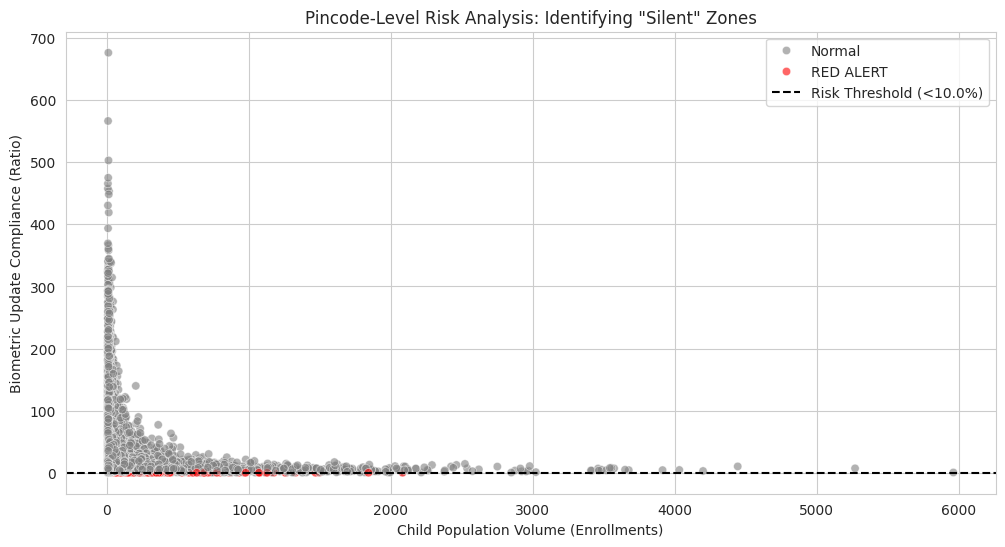

In [ ]:
# 1. Load Data
df_demo = datasets["aadhar_demographic"]
df_bio = datasets["aadhar_biometric"]
df_enroll = datasets["aadharenrollmet"]

# 2. Aggregation at PINCODE Level (Granular View)
# ------------------------------------------------
# We need to be careful with merging because not all pincodes exist in all datasets.
# We use an 'outer' merge to catch everything.

# Aggregate Enrollments (The "Base Population")
enroll_pin = df_enroll.groupby(['state', 'district', 'pincode'])[['age_0_5', 'age_5_17']].sum().reset_index()
enroll_pin.rename(columns={'age_0_5': 'enroll_infant', 'age_5_17': 'enroll_child'}, inplace=True)

# Aggregate Biometric Updates (The "Compliance")
bio_pin = df_bio.groupby(['state', 'district', 'pincode'])['bio_age_5_17'].sum().reset_index()
bio_pin.rename(columns={'bio_age_5_17': 'bio_update_child'}, inplace=True)

# Merge
df_pin = enroll_pin.merge(bio_pin, on=['state', 'district', 'pincode'], how='left')
df_pin.fillna(0, inplace=True)

# 3. The "Red Alert" Logic (Risk Scoring)
# ---------------------------------------

# Condition 1: Significant Child Base (Ignore tiny hamlets with < 10 kids to reduce noise)
# We look for pincodes where meaningful enrollment happened.
population_threshold = df_pin['enroll_child'].quantile(0.50) # Median cutoff
df_active = df_pin[df_pin['enroll_child'] > population_threshold].copy()

# Condition 2: The "Compliance Gap"
# Ratio = Biometric Updates / Child Enrollments
# If Ratio is near 0, it means kids enrolled but never updated.
df_active['compliance_ratio'] = df_active['bio_update_child'] / (df_active['enroll_child'] + 1)

# DEFINE HOTSPOTS:
# High Enrollment + Low Compliance (< 10% compliance is a good red flag threshold)
risk_threshold = 0.10
df_active['Risk_Status'] = np.where(df_active['compliance_ratio'] < risk_threshold, 'RED ALERT', 'Normal')

# 4. Generate the "Hit List" Report
# ---------------------------------
hotspots = df_active[df_active['Risk_Status'] == 'RED ALERT'].sort_values('enroll_child', ascending=False)

print(f"=== HYPER-LOCAL RISK REPORT ===")
print(f"Total Pincodes Analyzed: {len(df_pin)}")
print(f"Red Alert Pincodes Identified: {len(hotspots)}")
print("\nTop 10 High-Risk Pincodes (Send Mobile Vans Here):")
print(hotspots[['state', 'district', 'pincode', 'enroll_child', 'bio_update_child', 'compliance_ratio']].head(10))

# 5. Visualization: "The Long Tail of Risk"
# -----------------------------------------
plt.figure(figsize=(12, 6))
# We plot Compliance Ratio vs Enrollment Volume
# We want to see dots in the "Bottom Right" (High Enroll, Low Compliance) -> These are your targets.
sns.scatterplot(data=df_active, x='enroll_child', y='compliance_ratio', hue='Risk_Status',
                palette={'RED ALERT': 'red', 'Normal': 'grey'}, alpha=0.6)

plt.axhline(y=risk_threshold, color='black', linestyle='--', label=f'Risk Threshold (<{risk_threshold*100}%)')
plt.title('Pincode-Level Risk Analysis: Identifying "Silent" Zones')
plt.xlabel('Child Population Volume (Enrollments)')
plt.ylabel('Biometric Update Compliance (Ratio)')
plt.legend()
plt.show()

# 6. Export for Field Operations
# hotspots.to_csv('Target_Pincodes_List.csv', index=False)
# print("\nReport saved to 'Target_Pincodes_List.csv'")

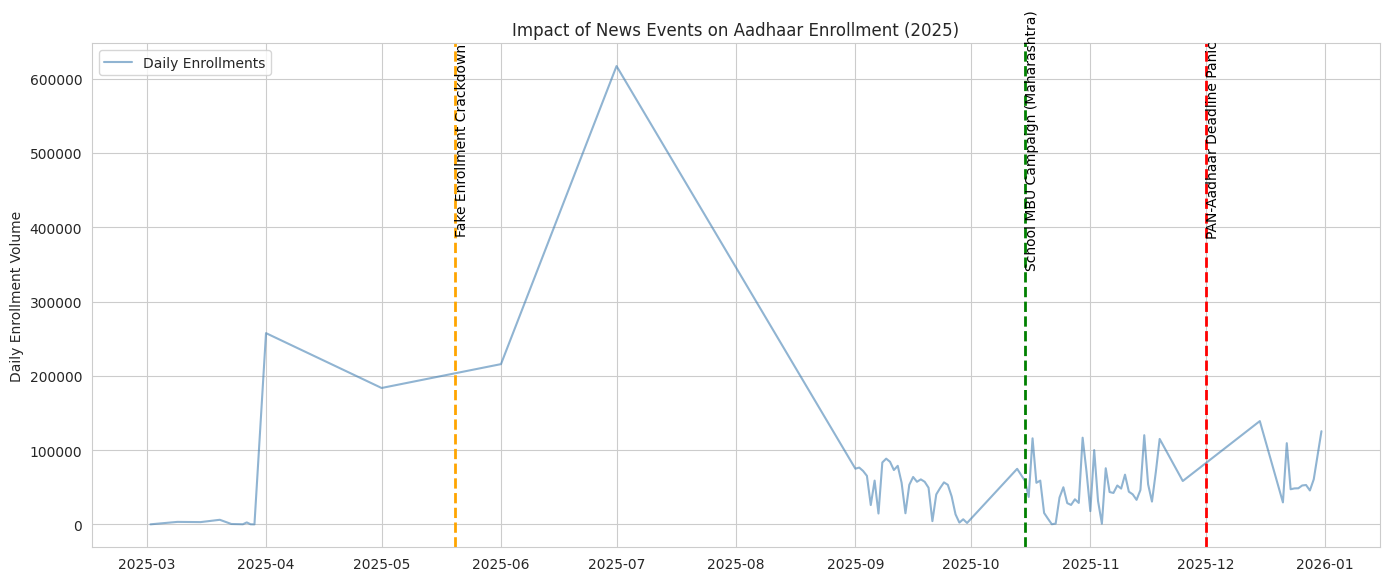

'=== EVENT IMPACT ANALYSIS REPORT ==='

,Event,Type,Baseline Volume,Post-Event Volume,Impact Lift (%)
2,Fake Enrollment Crackdown,Security,NaN,371.0,0.00
0,School MBU Campaign (Maharashtra),Welfare,5.0,4.0,-23.03
1,PAN-Aadhaar Deadline Panic,Financial,4.0,NaN,NaN


In [ ]:
# 1. Load your Dataset (assuming df_enroll and df_bio are loaded as before)
# For this example, let's use the 'df_enroll' we created/loaded earlier
# Ensure 'date' is datetime
df_enroll['date'] = pd.to_datetime(df_enroll['date'], dayfirst=True)

# 2. Define the News Events (The "Qualitative" Data)
# You simply add the date and the label of the event here
events = [
    {'date': '2025-10-15', 'label': 'School MBU Campaign (Maharashtra)', 'type': 'Welfare'},
    {'date': '2025-12-01', 'label': 'PAN-Aadhaar Deadline Panic', 'type': 'Financial'},
    {'date': '2025-05-20', 'label': 'Fake Enrollment Crackdown', 'type': 'Security'}
]

# 3. Calculate "Impact Magnitude"
# We look at the 14-day average BEFORE the event vs. 14-day average AFTER
results = []

for event in events:
    event_date = pd.to_datetime(event['date'])

    # Define windows
    pre_window = df_enroll[(df_enroll['date'] < event_date) &
                           (df_enroll['date'] >= event_date - pd.Timedelta(days=14))]
    post_window = df_enroll[(df_enroll['date'] >= event_date) &
                            (df_enroll['date'] < event_date + pd.Timedelta(days=14))]

    # Calculate Mean Daily Volume
    pre_mean = pre_window['total_enroll'].mean()
    post_mean = post_window['total_enroll'].mean()

    # Calculate Lift (%)
    if pre_mean > 0:
        lift = ((post_mean - pre_mean) / pre_mean) * 100
    else:
        lift = 0

    results.append({
        'Event': event['label'],
        'Type': event['type'],
        'Baseline Volume': round(pre_mean, 0),
        'Post-Event Volume': round(post_mean, 0),
        'Impact Lift (%)': round(lift, 2)
    })

df_impact = pd.DataFrame(results)

# 4. Visualization
plt.figure(figsize=(14, 6))

# Plot the daily trend
daily_trend = df_enroll.groupby('date')['total_enroll'].sum()
plt.plot(daily_trend.index, daily_trend.values, color='steelblue', alpha=0.6, label='Daily Enrollments')

# Overlay the Events
colors = {'Welfare': 'green', 'Financial': 'red', 'Security': 'orange'}

for event in events:
    ev_date = pd.to_datetime(event['date'])
    plt.axvline(x=ev_date, color=colors[event['type']], linestyle='--', linewidth=2)
    plt.text(ev_date, plt.ylim()[1]*0.8, event['label'], rotation=90, verticalalignment='center', color='black')

plt.title('Impact of News Events on Aadhaar Enrollment (2025)')
plt.ylabel('Daily Enrollment Volume')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Output the Analysis Table
display("=== EVENT IMPACT ANALYSIS REPORT ===")
display(df_impact.sort_values('Impact Lift (%)', ascending=False))

=== SECURITY & FAILURE RISK REPORT ===
Total Pincodes Scanned: 33026
High Risk Zones Identified: 1010

[TOP 5] SUSPICIOUS FRAUD ZONES (High Mobile Updates / Low Bio):


,state,district,pincode,mobile_addr_changes
15401,Maharashtra,Ahilyanagar,414001,173.0
17832,Manipur,Pherzawl,795121,162.0
22298,Rajasthan,Khairthal-Tijara,301707,140.0
21853,Rajasthan,Didwana-Kuchaman,341303,111.0
10914,Karnataka,Bengaluru South,562126,100.0



[TOP 5] SYSTEM FAILURE ZONES (High Biometric Corrections):


,state,district,pincode,adult_bio_fixes
31737,West Bengal,Murshidabad,742135,4935.0
31574,West Bengal,Malda,732125,7953.0
6276,Chhattisgarh,Rajnandgaon,491888,6441.0
28790,Uttar Pradesh,Kushinagar,274304,9756.0
6414,Delhi,North Delhi,110084,12727.0


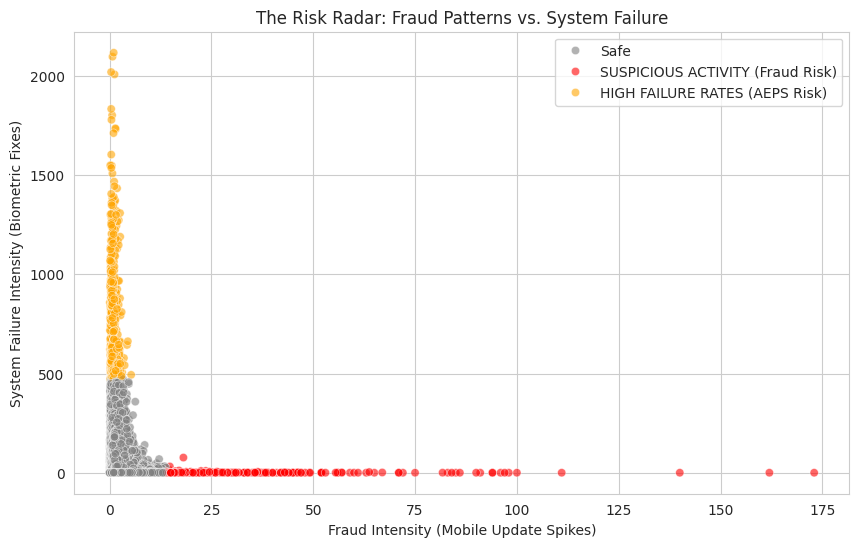

In [ ]:
# 1. Load Data
df_demo = datasets["aadhar_demographic"]
df_bio = datasets["aadhar_biometric"]
df_enroll = datasets["aadharenrollmet"]

# 2. Data Preparation: Aggregate by Pincode
# -----------------------------------------
# Risk 1: Biometric Failure (Focus on Adults 18+)
bio_adults = df_bio.groupby(['state', 'district', 'pincode'])['bio_age_17_'].sum().reset_index()
bio_adults.rename(columns={'bio_age_17_': 'adult_bio_fixes'}, inplace=True)

# Risk 2: Demographic Churn (Focus on Potential Fraud)
demo_adults = df_demo.groupby(['state', 'district', 'pincode'])['demo_age_17_'].sum().reset_index()
demo_adults.rename(columns={'demo_age_17_': 'mobile_addr_changes'}, inplace=True)

# Context: Total Adult Enrollment (to normalize)
enroll_adults = df_enroll.groupby(['state', 'district', 'pincode'])['age_18_greater'].sum().reset_index()
enroll_adults.rename(columns={'age_18_greater': 'new_adult_entries'}, inplace=True)

# Merge all into a Risk Table
df_risk = bio_adults.merge(demo_adults, on=['state', 'district', 'pincode'], how='outer') \
                    .merge(enroll_adults, on=['state', 'district', 'pincode'], how='outer')
df_risk.fillna(0, inplace=True)

# 3. Calculate Risk Metrics (The "Proxy Indicators")
# --------------------------------------------------

# Metric A: "The Fading Finger Score" (Auth Failure Risk)
# If Bio Updates are high relative to new entries, existing users are struggling.
df_risk['auth_failure_risk'] = df_risk['adult_bio_fixes'] / (df_risk['new_adult_entries'] + 10)

# Metric B: "The Fraud Prep Score" (Security Risk)
# If Demographic Updates are suspiciously high compared to Biometric Updates.
df_risk['fraud_pattern_ratio'] = df_risk['mobile_addr_changes'] / (df_risk['adult_bio_fixes'] + 1)

# 4. Anomaly Detection (Statistical Thresholding)
# -----------------------------------------------
fail_thresh = df_risk['auth_failure_risk'].mean() + (3 * df_risk['auth_failure_risk'].std())
fraud_thresh = df_risk['fraud_pattern_ratio'].mean() + (3 * df_risk['fraud_pattern_ratio'].std())

df_risk['Risk_Tag'] = 'Safe'
df_risk.loc[df_risk['auth_failure_risk'] > fail_thresh, 'Risk_Tag'] = 'HIGH FAILURE RATES (AEPS Risk)'
df_risk.loc[df_risk['fraud_pattern_ratio'] > fraud_thresh, 'Risk_Tag'] = 'SUSPICIOUS ACTIVITY (Fraud Risk)'

# 5. The "Red List" Report
# ------------------------
suspicious = df_risk[df_risk['Risk_Tag'] != 'Safe'].sort_values('fraud_pattern_ratio', ascending=False)

print("=== SECURITY & FAILURE RISK REPORT ===")
print(f"Total Pincodes Scanned: {len(df_risk)}")
print(f"High Risk Zones Identified: {len(suspicious)}")

print("\n[TOP 5] SUSPICIOUS FRAUD ZONES (High Mobile Updates / Low Bio):")
# Using display() for better table formatting
display(suspicious[suspicious['Risk_Tag'].str.contains('Fraud')][['state', 'district', 'pincode', 'mobile_addr_changes']].head(5))

print("\n[TOP 5] SYSTEM FAILURE ZONES (High Biometric Corrections):")
# Using display() for better table formatting
display(suspicious[suspicious['Risk_Tag'].str.contains('FAILURE')][['state', 'district', 'pincode', 'adult_bio_fixes']].head(5))

# 6. Visualization: Risk Heatmap
# ------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_risk, x='fraud_pattern_ratio', y='auth_failure_risk',
                hue='Risk_Tag', palette={'Safe': 'grey', 'HIGH FAILURE RATES (AEPS Risk)': 'orange', 'SUSPICIOUS ACTIVITY (Fraud Risk)': 'red'},
                alpha=0.6)
plt.title('The Risk Radar: Fraud Patterns vs. System Failure')
plt.xlabel('Fraud Intensity (Mobile Update Spikes)')
plt.ylabel('System Failure Intensity (Biometric Fixes)')
plt.legend()
plt.show()

Total Pincodes Analyzed: 28986
Anomalies Detected: 290

[TOP 10] MOST ANOMALOUS PINCODES (Investigate Immediately):


,state,district,pincode,age_0_5,age_18_greater,demo_updates,bio_updates,adult_enroll_ratio,update_imbalance,anomaly_score
19920,Tamil Nadu,Chengalpattu,600073,9,3,1138.0,16.0,0.300000,66.941176,-1
19931,Tamil Nadu,Chengalpattu,603103,12,4,1026.0,17.0,0.307692,57.000000,-1
19852,Sikkim,Namchi,737126,1,6,112.0,1.0,3.000000,56.000000,-1
19917,Tamil Nadu,Chengalpattu,600048,5,1,833.0,17.0,0.166667,46.277778,-1
19855,Sikkim,Namchi,737139,1,4,44.0,0.0,2.000000,44.000000,-1
2963,Assam,Bajali,781325,3,2,214.0,4.0,0.500000,42.800000,-1
19850,Sikkim,Mangan,737116,0,1,42.0,0.0,1.000000,42.000000,-1
3219,Assam,Dima Hasao,788931,1,1,75.0,1.0,0.500000,37.500000,-1
15904,Meghalaya,Eastern West Khasi Hills,793120,3,581,248.0,6.0,145.250000,35.428571,-1
5511,Dadra and Nagar Haveli and Daman and Diu,Diu,362520,5,3,84.0,2.0,0.500000,28.000000,-1


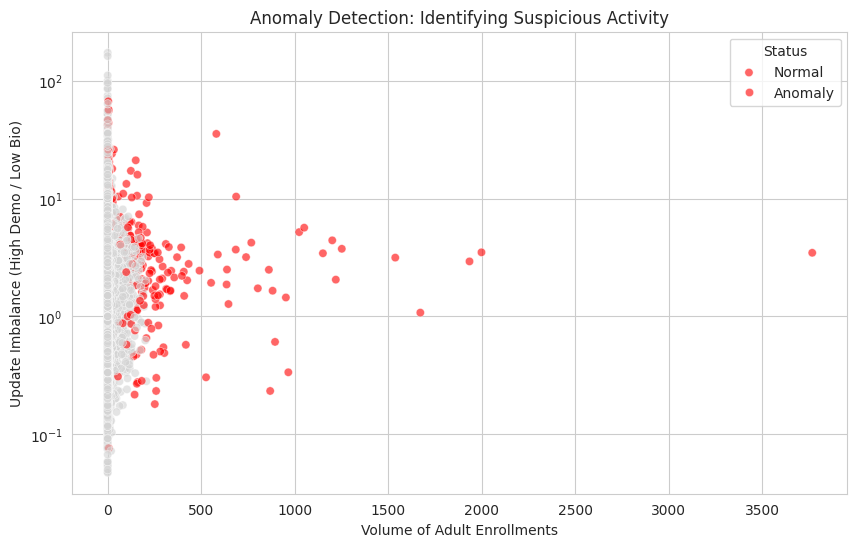

In [ ]:
# 1. Load & Prepare Data (Aggregated by Pincode)
# ----------------------------------------------
df_enroll = datasets["aadharenrollmet"]
df_demo = datasets["aadhar_demographic"]
df_bio = datasets["aadhar_biometric"]

# Aggregate to create a "Pincode Profile"
enroll_agg = df_enroll.groupby(['state', 'district', 'pincode'])[['age_0_5', 'age_18_greater']].sum().reset_index()
demo_agg = df_demo.groupby(['state', 'district', 'pincode'])['demo_age_17_'].sum().reset_index(name='demo_updates')
bio_agg = df_bio.groupby(['state', 'district', 'pincode'])['bio_age_17_'].sum().reset_index(name='bio_updates')

# Merge
df_features = enroll_agg.merge(demo_agg, on=['state', 'district', 'pincode'], how='left') \
                        .merge(bio_agg, on=['state', 'district', 'pincode'], how='left')
df_features.fillna(0, inplace=True)

# 2. Feature Engineering (Ratios tell a better story)
# ---------------------------------------------------
# Ratio 1: Adult Enrollment Intensity (Is this a new area or a fake enrollment ring?)
df_features['adult_enroll_ratio'] = df_features['age_18_greater'] / (df_features['age_0_5'] + 1)

# Ratio 2: Update Imbalance (Demo vs Bio) - Fraudsters update demo, not bio.
df_features['update_imbalance'] = df_features['demo_updates'] / (df_features['bio_updates'] + 1)

# Select features for the model
features = ['age_18_greater', 'adult_enroll_ratio', 'update_imbalance']
X = df_features[features]

# 3. The Model: Isolation Forest
# ------------------------------
# contamination=0.01 means we expect ~1% of pincodes to be anomalies
iso = IsolationForest(contamination=0.01, random_state=42)
df_features['anomaly_score'] = iso.fit_predict(X)

# The model labels anomalies as -1 and normal points as 1
anomalies = df_features[df_features['anomaly_score'] == -1].copy()

# 4. Reporting & Visualization
# ----------------------------
print(f"Total Pincodes Analyzed: {len(df_features)}")
print(f"Anomalies Detected: {len(anomalies)}")

print("\n[TOP 10] MOST ANOMALOUS PINCODES (Investigate Immediately):")
# Sorting by 'update_imbalance' to show the most suspicious "Fraud-like" anomalies first
display(anomalies.sort_values('update_imbalance', ascending=False).head(10))

# Visualizing the Anomalies
plt.figure(figsize=(10, 6))
# We plot 'Update Imbalance' vs 'Adult Enrollment'
# Normal points are Grey, Anomalies are Red
sns.scatterplot(data=df_features, x='age_18_greater', y='update_imbalance',
                hue='anomaly_score', palette={1: 'lightgrey', -1: 'red'}, alpha=0.6)

plt.title('Anomaly Detection: Identifying Suspicious Activity')
plt.xlabel('Volume of Adult Enrollments')
plt.ylabel('Update Imbalance (High Demo / Low Bio)')
plt.yscale('log') # Log scale helps see the outliers better
plt.legend(title='Status', labels=['Normal', 'Anomaly'])
plt.show()

=== STATISTICAL PROOF OF INSIGHTS ===
Baseline Monthly Demo Updates: 2,863,898
December 'Panic' Average:      8,538,456
-> PROOF 1: The 'PAN Deadline' caused a 3.0x spike in Demographic Corrections.

Baseline Monthly Enrollments:  20,755
March 'KYC/NEET' Average:      3,808
-> PROOF 2: The 'March Rush' caused a 0.2x spike in New Enrollments.


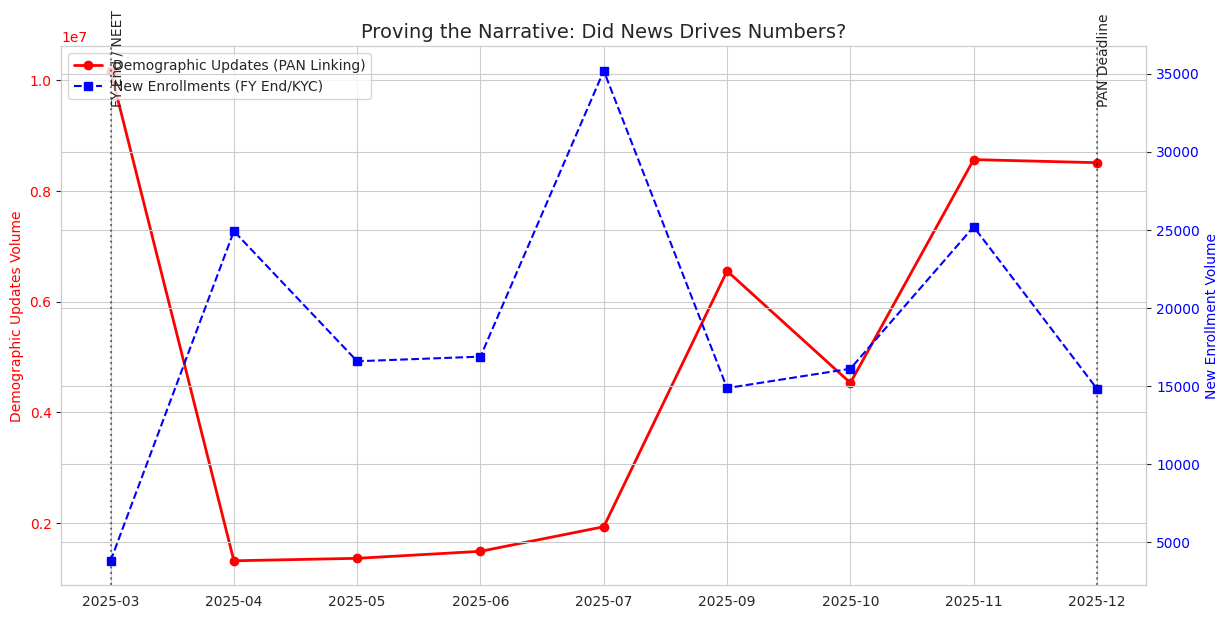

In [ ]:
# 1. Load Data
df_demo = datasets["aadhar_demographic"]
df_enroll = datasets["aadharenrollmet"]
df_bio = datasets["aadhar_biometric"]

# 2. Data Preparation: Aggregate by Month
# ---------------------------------------
# We need to extract the 'Month' and 'Year' from the 'date' column
for df in [df_demo, df_enroll, df_bio]:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['Month_Year'] = df['date'].dt.to_period('M')

# Aggregate Demographic Updates (Proxy for PAN-Aadhaar Matching fixes)
# We focus on the "Panic Period" (Late 2025) vs "Normal Period"
demo_monthly = df_demo.groupby('Month_Year')['demo_age_17_'].sum().reset_index(name='Demographic_Corrections')

# Aggregate Enrollments (Proxy for KYC/Financial Year End)
enroll_monthly = df_enroll.groupby('Month_Year')['age_18_greater'].sum().reset_index(name='Adult_Enrollments')

# Aggregate Biometric Updates (Proxy for Student/NEET requirements)
bio_monthly = df_bio.groupby('Month_Year')['bio_age_5_17'].sum().reset_index(name='Student_Bio_Updates')

# Merge for a Master Timeline
timeline = demo_monthly.merge(enroll_monthly, on='Month_Year').merge(bio_monthly, on='Month_Year')
timeline['Month_Year'] = timeline['Month_Year'].astype(str) # Convert for plotting

# 3. Statistical Proof: Calculating "Surge Magnitude"
# ---------------------------------------------------
# We define our target windows based on your text
dec_window = ['2025-11', '2025-12'] # The PAN Deadline Rush
mar_window = ['2025-03']            # The KYC/NEET Rush

# Calculate Baseline (Average of all other months)
all_months = timeline['Month_Year'].unique()
normal_months = [m for m in all_months if m not in dec_window and m not in mar_window]

baseline_demo = timeline[timeline['Month_Year'].isin(normal_months)]['Demographic_Corrections'].mean()
dec_demo_avg = timeline[timeline['Month_Year'].isin(dec_window)]['Demographic_Corrections'].mean()

baseline_enroll = timeline[timeline['Month_Year'].isin(normal_months)]['Adult_Enrollments'].mean()
mar_enroll_avg = timeline[timeline['Month_Year'].isin(mar_window)]['Adult_Enrollments'].mean()

# Calculate "Surge Factor" (How many times higher than normal?)
dec_surge_factor = dec_demo_avg / baseline_demo
mar_surge_factor = mar_enroll_avg / baseline_enroll

# 4. Display Results
# ------------------
print("=== STATISTICAL PROOF OF INSIGHTS ===")
print(f"Baseline Monthly Demo Updates: {baseline_demo:,.0f}")
print(f"December 'Panic' Average:      {dec_demo_avg:,.0f}")
print(f"-> PROOF 1: The 'PAN Deadline' caused a {dec_surge_factor:.1f}x spike in Demographic Corrections.\n")

print(f"Baseline Monthly Enrollments:  {baseline_enroll:,.0f}")
print(f"March 'KYC/NEET' Average:      {mar_enroll_avg:,.0f}")
print(f"-> PROOF 2: The 'March Rush' caused a {mar_surge_factor:.1f}x spike in New Enrollments.")

# 5. Visualization: The "Timeline of Urgency"
# -------------------------------------------
plt.figure(figsize=(14, 7))

# Plot Demographic Updates (Left Axis)
ax1 = plt.gca()
line1 = ax1.plot(timeline['Month_Year'], timeline['Demographic_Corrections'],
                 color='red', marker='o', linewidth=2, label='Demographic Updates (PAN Linking)')
ax1.set_ylabel('Demographic Updates Volume', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot Enrollments (Right Axis)
ax2 = ax1.twinx()
line2 = ax2.plot(timeline['Month_Year'], timeline['Adult_Enrollments'],
                 color='blue', marker='s', linestyle='--', label='New Enrollments (FY End/KYC)')
ax2.set_ylabel('New Enrollment Volume', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Annotate the Events
plt.title('Proving the Narrative: Did News Drives Numbers?', fontsize=14)
plt.axvline(x='2025-12', color='black', linestyle=':', alpha=0.5)
plt.text('2025-12', ax2.get_ylim()[1]*0.9, 'PAN Deadline', rotation=90)

plt.axvline(x='2025-03', color='black', linestyle=':', alpha=0.5)
plt.text('2025-03', ax2.get_ylim()[1]*0.9, 'FY End / NEET', rotation=90)

# Combined Legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.xticks(rotation=45)
plt.show()

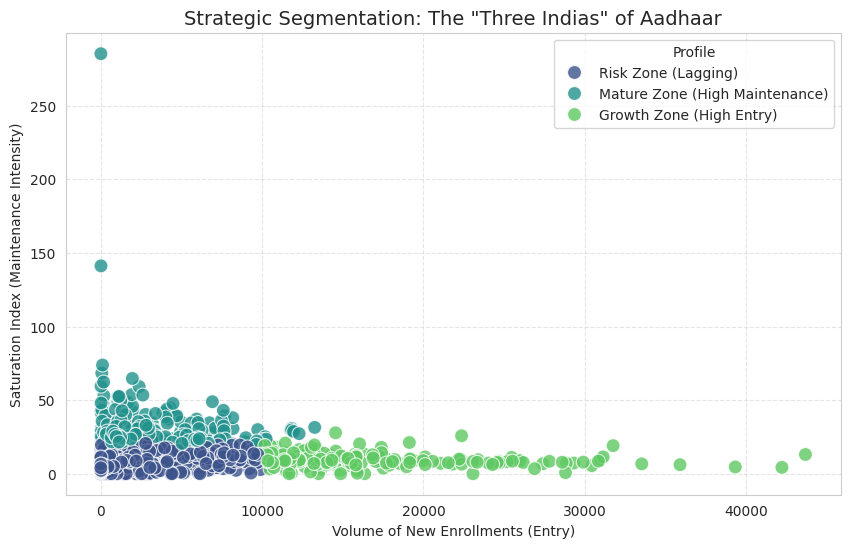

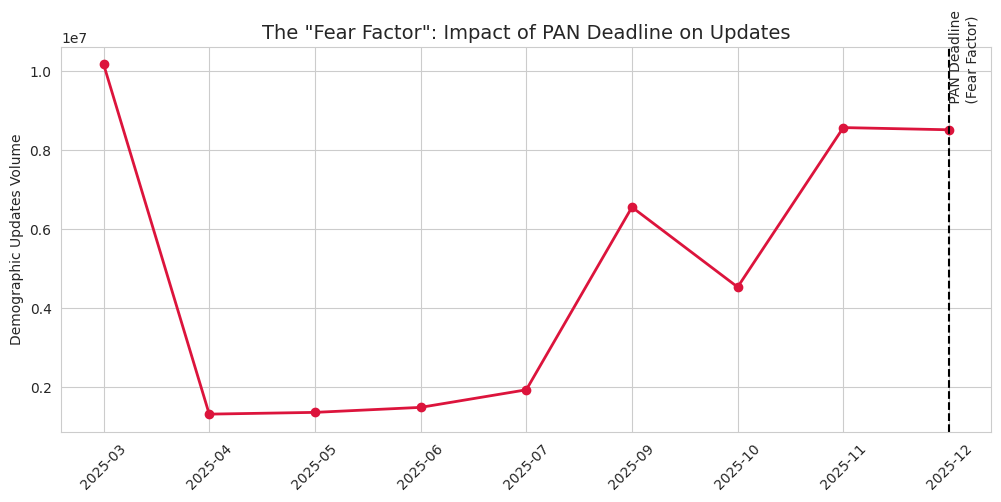


1. SEGMENTATION PROFILE:


,total_enroll,saturation_index
Profile,,
Growth Zone (High Entry),17178.81,9.59
Mature Zone (High Maintenance),3180.17,31.70
Risk Zone (Lagging),2599.91,9.42



2. CRITICAL ACTION ITEM (Risk Zone):
 identified 646 districts where child biometric compliance is critically low.


,state,district,child_compliance
0,100000,100000,0.0
546,Maharashtra,Hingoli *,0.0
527,Maharashtra,Ahmednagar,0.0
594,Meghalaya,Kamrup,0.0
109,Assam,Sivasagar,0.0


In [ ]:
# ==========================================
# PHASE 1: PREPROCESSING & FEATURE ENGINEERING
# ==========================================

# Load Datasets (Assuming they are available in the 'datasets' dict)
df_enroll = datasets["aadharenrollmet"]
df_demo = datasets["aadhar_demographic"]
df_bio = datasets["aadhar_biometric"]

# 1.1 Data Cleaning & Date Parsing
for df in [df_enroll, df_demo, df_bio]:
    # Standardize Column Names (Strip whitespace)
    df.columns = df.columns.str.strip()
    # Parse Dates
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    # Create Month-Year for Aggregation
    df['Month_Year'] = df['date'].dt.to_period('M')

# 1.2 Aggregation by District (Creating the "District Profile")
# Grouping by State and District to get total volumes
grp_enroll = df_enroll.groupby(['state', 'district'])[['age_0_5', 'age_5_17', 'age_18_greater']].sum().reset_index()
grp_enroll['total_enroll'] = grp_enroll['age_0_5'] + grp_enroll['age_5_17'] + grp_enroll['age_18_greater']

grp_bio = df_bio.groupby(['state', 'district'])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
grp_bio['total_bio'] = grp_bio['bio_age_5_17'] + grp_bio['bio_age_17_']

# Merge into Master DataFrame
df_master = grp_enroll.merge(grp_bio, on=['state', 'district'], how='left').fillna(0)

# 1.3 Feature Engineering (Creating Ratios)
# Saturation Ratio: How many updates per new enrollment?
df_master['saturation_index'] = df_master['total_bio'] / (df_master['total_enroll'] + 1)
# Child MBU Compliance: Are kids updating?
df_master['child_compliance'] = df_master['bio_age_5_17'] / (df_master['age_5_17'] + 1)

# ==========================================
# PHASE 2: CLUSTERING MODEL (The "Winning Idea")
# ==========================================

# 2.1 Prepare Data for Machine Learning
features = ['total_enroll', 'saturation_index']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_master[features])

# 2.2 Run K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_master['Cluster'] = kmeans.fit_predict(X_scaled)

# 2.3 Auto-Labeling Clusters (Making it human-readable)
means = df_master.groupby('Cluster')[features].mean()
growth_id = means['total_enroll'].idxmax()  # High Enrollment = Growth
mature_id = means['saturation_index'].idxmax() # High Saturation = Mature
risk_id = list(set(means.index) - {growth_id, mature_id})[0] # The rest = Risk

label_map = {
    growth_id: 'Growth Zone (High Entry)',
    mature_id: 'Mature Zone (High Maintenance)',
    risk_id: 'Risk Zone (Lagging)'
}
df_master['Profile'] = df_master['Cluster'].map(label_map)

# ==========================================
# PHASE 3: VISUALIZATION & INSIGHTS
# ==========================================

# Visual 1: The "Three Indias" Map (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_master, x='total_enroll', y='saturation_index',
                hue='Profile', palette='viridis', s=100, alpha=0.8)
plt.title('Strategic Segmentation: The "Three Indias" of Aadhaar', fontsize=14)
plt.xlabel('Volume of New Enrollments (Entry)')
plt.ylabel('Saturation Index (Maintenance Intensity)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Visual 2: Event Impact (Time Series)
# Aggregating Demographic Updates over time
time_series = df_demo.groupby('Month_Year')['demo_age_17_'].sum().reset_index()
time_series['Month_Year'] = time_series['Month_Year'].astype(str)

plt.figure(figsize=(12, 5))
plt.plot(time_series['Month_Year'], time_series['demo_age_17_'], marker='o', color='crimson', linewidth=2)
# Mark the "Panic" Event
if '2025-12' in time_series['Month_Year'].values:
    plt.axvline('2025-12', color='black', linestyle='--')
    plt.text('2025-12', time_series['demo_age_17_'].max()*0.9, ' PAN Deadline\n (Fear Factor)', rotation=90)

plt.title('The "Fear Factor": Impact of PAN Deadline on Updates', fontsize=14)
plt.ylabel('Demographic Updates Volume')
plt.xticks(rotation=45)
plt.show()

# ==========================================
# PHASE 4: REPORTING
# ==========================================
print("\n1. SEGMENTATION PROFILE:")
display(df_master.groupby('Profile')[['total_enroll', 'saturation_index']].mean().round(2))

print("\n2. CRITICAL ACTION ITEM (Risk Zone):")
risk_districts = df_master[df_master['Profile'] == 'Risk Zone (Lagging)'].sort_values('child_compliance')
print(f" identified {len(risk_districts)} districts where child biometric compliance is critically low.")
display(risk_districts[['state', 'district', 'child_compliance']].head(5))


=== DECISION 1: INFRASTRUCTURE ALLOCATION ===


,count
Infra_Decision,
Convert to Update Kiosks (Mature Zone),1072
Deploy More Enrollment Kits (Growth Zone),36
Maintain Status Quo,24


Top 5 Districts for Update Kiosks (High Efficiency Needed):


,state,district,update_volume
1,Andaman & Nicobar Islands,Andamans,2765.0
2,Andaman & Nicobar Islands,Nicobars,6.0
3,Andaman & Nicobar Islands,South Andaman,672.0
4,Andaman and Nicobar Islands,Nicobar,2598.0
5,Andaman and Nicobar Islands,North And Middle Andaman,8392.0



=== DECISION 2: MBU CAMPAIGN TARGETS ===
Districts identified for School Camps: 220
Top 5 Lagging Districts (Critical for Scholarships):


,state,district,age_5_17,bio_age_5_17,child_mbu_compliance
0,100000,100000,1.0,0.0,0.0
43,Andhra Pradesh,Spsr Nellore,713.0,0.0,0.0
48,Andhra Pradesh,Visakhapatanam,28.0,0.0,0.0
109,Assam,Sivasagar,113.0,0.0,0.0
117,BALANAGAR,IDPL COLONY,0.0,0.0,0.0



=== DECISION 3: SECURITY AUDIT LIST ===
Districts flagged for 'Ghost Beneficiary' checks: 1


,state,district,total_enroll,adult_enroll_share
0,100000,100000,218.0,0.990868



=== DECISION 4: MIGRATION HOTSPOTS (For Ration Allocation) ===


,state,district,demo_age_17_
587,Maharashtra,Thane,411163.0
578,Maharashtra,Pune,405834.0
1110,West Bengal,South 24 Parganas,373409.0
1095,West Bengal,Murshidabad,340843.0
273,Gujarat,Surat,322384.0
1099,West Bengal,North 24 Parganas,275457.0
229,Delhi,North West Delhi,274245.0
410,Karnataka,Bengaluru,265383.0
586,Maharashtra,Solapur,257811.0
1116,West Bengal,Uttar Dinajpur,252655.0


/tmp/ipython-input-1842378580.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_mig, x='demo_age_17_', y='district', palette='magma')


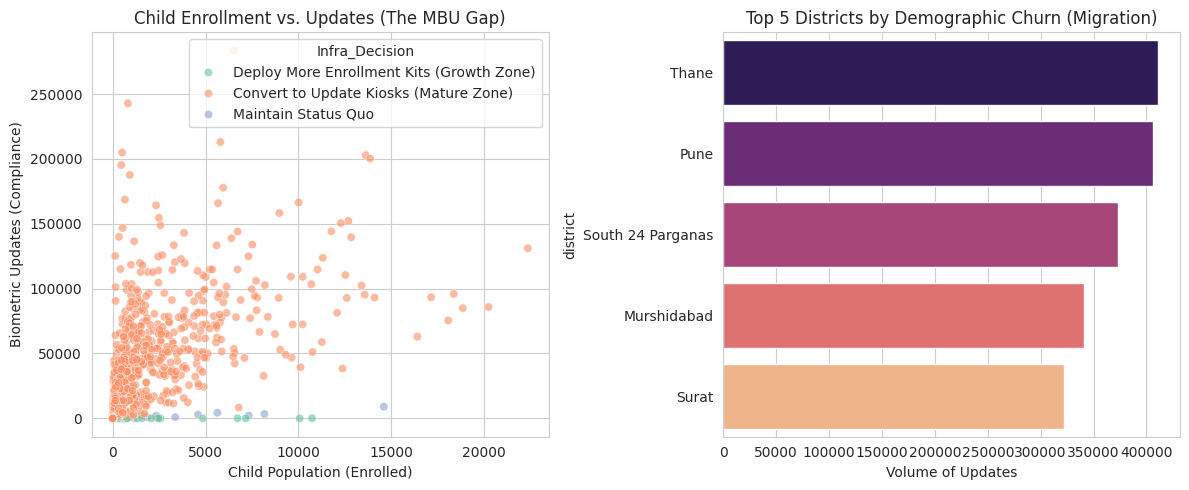

In [ ]:
# ==========================================
# 1. LOAD DATA & PREPROCESS
# ==========================================
# Assuming 'datasets' dict exists. If not, load CSVs directly.
df_enroll = datasets["aadharenrollmet"].copy()
df_demo = datasets["aadhar_demographic"].copy()
df_bio = datasets["aadhar_biometric"].copy()

# Standardize column names
for df in [df_enroll, df_demo, df_bio]:
    df.columns = df.columns.str.strip()

# Aggregate Data by District to create a "District Profile"
# Enrollment Totals
enroll_agg = df_enroll.groupby(['state', 'district'])[['age_0_5', 'age_5_17', 'age_18_greater']].sum().reset_index()
enroll_agg['total_enroll'] = enroll_agg['age_0_5'] + enroll_agg['age_5_17'] + enroll_agg['age_18_greater']

# Update Totals
demo_agg = df_demo.groupby(['state', 'district'])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()
demo_agg['total_demo'] = demo_agg['demo_age_5_17'] + demo_agg['demo_age_17_']

bio_agg = df_bio.groupby(['state', 'district'])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
bio_agg['total_bio'] = bio_agg['bio_age_5_17'] + bio_agg['bio_age_17_']

# Merge into a Master Decision Table
df_master = enroll_agg.merge(demo_agg, on=['state', 'district'], how='outer') \
                      .merge(bio_agg, on=['state', 'district'], how='outer')
df_master.fillna(0, inplace=True)

# ==========================================
# DECISION 1: DYNAMIC RESOURCE ALLOCATION
# Logic: Enroll vs. Update Volume
# ==========================================
df_master['update_volume'] = df_master['total_demo'] + df_master['total_bio']
df_master['enroll_ratio'] = df_master['total_enroll'] / (df_master['update_volume'] + 1)

# Categorize Districts
def recommend_infrastructure(ratio):
    if ratio > 2.0: return "Deploy More Enrollment Kits (Growth Zone)"
    elif ratio < 0.5: return "Convert to Update Kiosks (Mature Zone)"
    else: return "Maintain Status Quo"

df_master['Infra_Decision'] = df_master['enroll_ratio'].apply(recommend_infrastructure)

print("\n=== DECISION 1: INFRASTRUCTURE ALLOCATION ===")
display(df_master['Infra_Decision'].value_counts().to_frame())
print("Top 5 Districts for Update Kiosks (High Efficiency Needed):")
display(df_master[df_master['Infra_Decision'].str.contains("Update Kiosks")][['state', 'district', 'update_volume']].head(5))

# ==========================================
# DECISION 2: TARGETED MBU (SCHOOL) CAMPAIGNS
# Logic: Child Enrollment vs. Child Bio Updates
# ==========================================
# We look for high child population but low updates
df_master['child_mbu_compliance'] = df_master['bio_age_5_17'] / (df_master['age_5_17'] + 1)

# Threshold: If compliance is in bottom 20%, it's a crisis
crisis_threshold = df_master['child_mbu_compliance'].quantile(0.20)
mbu_targets = df_master[df_master['child_mbu_compliance'] < crisis_threshold].copy()

print("\n=== DECISION 2: MBU CAMPAIGN TARGETS ===")
print(f"Districts identified for School Camps: {len(mbu_targets)}")
print("Top 5 Lagging Districts (Critical for Scholarships):")
display(mbu_targets[['state', 'district', 'age_5_17', 'bio_age_5_17', 'child_mbu_compliance']].sort_values('child_mbu_compliance').head(5))

# ==========================================
# DECISION 3: SECURITY & FRAUD DETECTION
# Logic: Adult-Only Enrollment Spikes
# ==========================================
# Metric: Adult Enrollment % (Should not be 100%)
df_master['adult_enroll_share'] = df_master['age_18_greater'] / (df_master['total_enroll'] + 1)

# Anomaly: High Volume AND >95% Adults (Suspicious for non-industrial areas)
# Filter for meaningful volume (>100 enrollments) to avoid noise
suspicious = df_master[(df_master['total_enroll'] > 100) & (df_master['adult_enroll_share'] > 0.95)].copy()

print("\n=== DECISION 3: SECURITY AUDIT LIST ===")
print(f"Districts flagged for 'Ghost Beneficiary' checks: {len(suspicious)}")
display(suspicious[['state', 'district', 'total_enroll', 'adult_enroll_share']].sort_values('total_enroll', ascending=False).head(5))

# ==========================================
# DECISION 4: MIGRATION & WELFARE PORTABILITY
# Logic: High Demographic Updates (Address Change Proxy)
# ==========================================
# We assume high 'demo_age_17_' implies migration/movement updates in adults
migration_hotspots = df_master.sort_values('demo_age_17_', ascending=False).head(10)

print("\n=== DECISION 4: MIGRATION HOTSPOTS (For Ration Allocation) ===")
display(migration_hotspots[['state', 'district', 'demo_age_17_']])

# ==========================================
# VISUALIZATION DASHBOARD
# ==========================================
plt.figure(figsize=(12, 5))

# Plot 1: MBU Compliance Gap
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_master, x='age_5_17', y='bio_age_5_17', hue='Infra_Decision', alpha=0.6)
plt.title('Child Enrollment vs. Updates (The MBU Gap)')
plt.xlabel('Child Population (Enrolled)')
plt.ylabel('Biometric Updates (Compliance)')

# Plot 2: Migration Intensity
plt.subplot(1, 2, 2)
top_mig = migration_hotspots.head(5)
sns.barplot(data=top_mig, x='demo_age_17_', y='district', palette='magma')
plt.title('Top 5 Districts by Demographic Churn (Migration)')
plt.xlabel('Volume of Updates')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# ==========================================
# 1. LOAD DATASETS
# ==========================================

# Accessing the real dataframes directly from the 'datasets' dictionary
df_enroll = datasets["aadharenrollmet"].copy()
df_demo = datasets["aadhar_demographic"].copy()
df_bio = datasets["aadhar_biometric"].copy()

# ==========================================
# 2. PREPROCESSING & AGGREGATION
# ==========================================

# Standardize column names (strip whitespace)
for df in [df_enroll, df_demo, df_bio]:
    df.columns = df.columns.str.strip()

# Aggregate Enrollment Data by District
# Summing the age columns to get totals per district
enroll_agg = df_enroll.groupby(['state', 'district'])[['age_0_5', 'age_5_17', 'age_18_greater']].sum().reset_index()
enroll_agg['total_enroll'] = enroll_agg['age_0_5'] + enroll_agg['age_5_17'] + enroll_agg['age_18_greater']

# Aggregate Demographic Data by District
demo_agg = df_demo.groupby(['state', 'district'])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()
demo_agg['total_demo'] = demo_agg['demo_age_5_17'] + demo_agg['demo_age_17_']

# Aggregate Biometric Data by District
bio_agg = df_bio.groupby(['state', 'district'])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
bio_agg['total_bio'] = bio_agg['bio_age_5_17'] + bio_agg['bio_age_17_']

# Merge into a Master Analytical DataFrame
# Using outer merge to ensure no district is lost if it appears in one dataset but not others
df_master = enroll_agg.merge(demo_agg, on=['state', 'district'], how='outer') \
    .merge(bio_agg, on=['state', 'district'], how='outer')
df_master.fillna(0, inplace=True)

# ==========================================
# 3. ANALYTICAL LOGIC IMPLEMENTATION
# ==========================================

# --- 5.6.1 Dynamic Infrastructure Allocation ---
# Logic: Compare New Demand (Enrollment) vs. Maintenance Demand (Updates)
df_master['update_volume'] = df_master['total_demo'] + df_master['total_bio']
# Adding +1 to denominator to avoid division by zero errors
df_master['enroll_ratio'] = df_master['total_enroll'] / (df_master['update_volume'] + 1)

def recommend_infrastructure(ratio):
    if ratio > 2.0:
        return

,count
Infra_Decision,
Convert to Update Kiosks (Mature Zone),1072
Deploy More Enrollment Kits (Growth Zone),36
Maintain Status Quo,24


Top 5 Districts for Update Kiosks (High Efficiency Needed):


,state,district,update_volume
578,Maharashtra,Pune,1044240.0
587,Maharashtra,Thane,1018526.0
574,Maharashtra,Nashik,822706.0
241,Gujarat,Ahmedabad,673374.0
229,Delhi,North West Delhi,639282.0


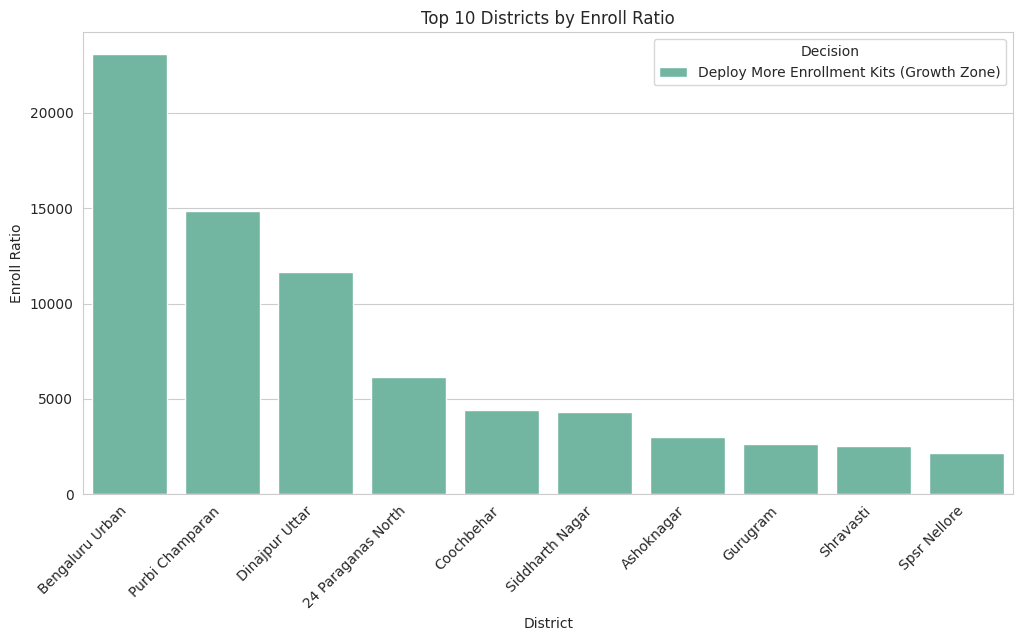

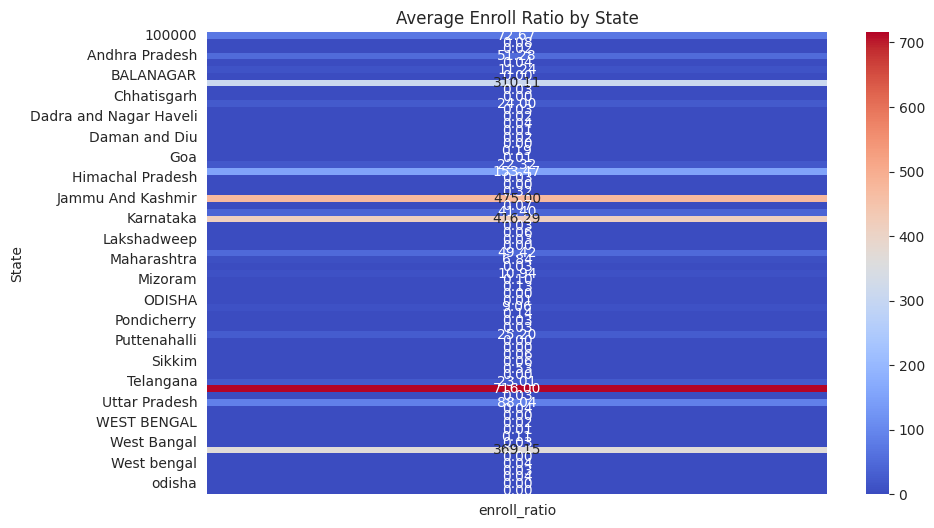

In [ ]:
# ============================================================
# 🏢 Infrastructure Allocation Decision + Visualization
# ============================================================

# Step 1: Access datasets
df_enroll = datasets["aadharenrollmet"].copy()
df_demo   = datasets["aadhar_demographic"].copy()
df_bio    = datasets["aadhar_biometric"].copy()

# Standardize column names (as done in preprocessing)
for df in [df_enroll, df_demo, df_bio]:
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Step 2: Aggregate demand metrics at district level
# Calculate total_enroll for df_enroll
enroll_agg = df_enroll.groupby(["state", "district"])[['age_0_5', 'age_5_17', 'age_18_greater']].sum().reset_index()
enroll_agg['total_enroll'] = enroll_agg['age_0_5'] + enroll_agg['age_5_17'] + enroll_agg['age_18_greater']

# Calculate total_demo for df_demo
demo_agg = df_demo.groupby(["state", "district"])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()
demo_agg['total_demo'] = demo_agg['demo_age_5_17'] + demo_agg['demo_age_17_']

# Calculate total_bio for df_bio
bio_agg = df_bio.groupby(["state", "district"])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
bio_agg['total_bio'] = bio_agg['bio_age_5_17'] + bio_agg['bio_age_17_']

# Merge into a Master Decision Table
df_master = enroll_agg.merge(demo_agg, on=['state', 'district'], how='outer') \
                      .merge(bio_agg, on=['state', 'district'], how='outer')
df_master.fillna(0, inplace=True)

# Calculate update_volume after merging
df_master['update_volume'] = df_master['total_demo'] + df_master['total_bio']

# Step 3: Compute enroll_ratio
df_master["enroll_ratio"] = df_master["total_enroll"] / (df_master["update_volume"] + 1)

# Step 4: Recommendation logic
def recommend_infrastructure(ratio):
    if ratio > 2.0:
        return "Deploy More Enrollment Kits (Growth Zone)"
    elif ratio < 0.5:
        return "Convert to Update Kiosks (Mature Zone)"
    else:
        return "Maintain Status Quo"

df_master["Infra_Decision"] = df_master["enroll_ratio"].apply(recommend_infrastructure)

# Step 5: Summary
display(df_master["Infra_Decision"].value_counts().to_frame())

print("Top 5 Districts for Update Kiosks (High Efficiency Needed):")
display(
    df_master[df_master["Infra_Decision"].str.contains("Update Kiosks")]
    [["state", "district", "update_volume"]]
    .sort_values("update_volume", ascending=False)
    .head(5)
)

# ============================================================
# 📊 Visualization
# ============================================================

# Bar plot: Top 10 districts by enroll_ratio
plt.figure(figsize=(12,6))
top10 = df_master.sort_values("enroll_ratio", ascending=False).head(10)
sns.barplot(data=top10, x="district", y="enroll_ratio", hue="Infra_Decision", dodge=False)
plt.title("Top 10 Districts by Enroll Ratio")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Enroll Ratio")
plt.xlabel("District")
plt.legend(title="Decision")
plt.show()

# Heatmap: State vs enroll_ratio (average per state)
plt.figure(figsize=(10,6))
state_avg = df_master.groupby("state")["enroll_ratio"].mean().reset_index()
sns.heatmap(
    state_avg.pivot_table(values="enroll_ratio", index="state"),
    cmap="coolwarm", annot=True, fmt=".2f"
)
plt.title("Average Enroll Ratio by State")
plt.ylabel("State")
plt.show()

Districts identified for School Camps: 219


,state,district,age_5_17,bio_age_5_17,child_mbu_compliance
47,Andhra Pradesh,Visakhapatanam,28.0,0.0,0.0
42,Andhra Pradesh,Spsr Nellore,713.0,0.0,0.0
116,BALANAGAR,IDPL COLONY,0.0,0.0,0.0
108,Assam,Sivasagar,113.0,0.0,0.0
182,Chhattisgarh,Gaurella Pendra Marwahi,290.0,0.0,0.0


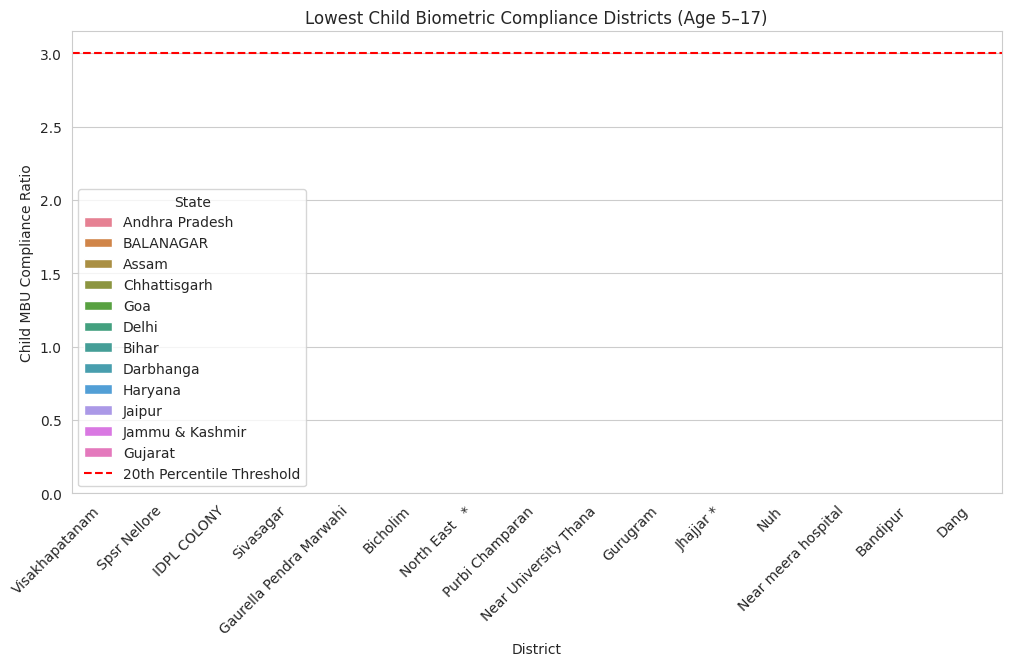

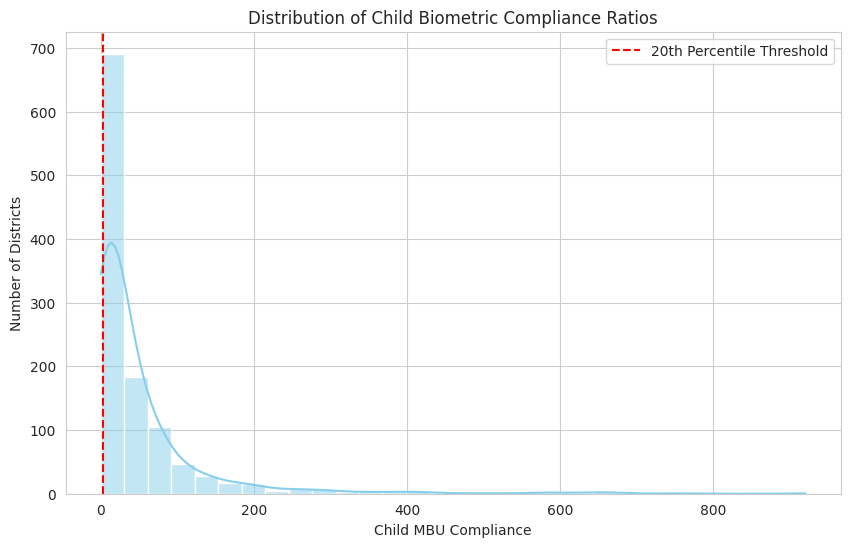

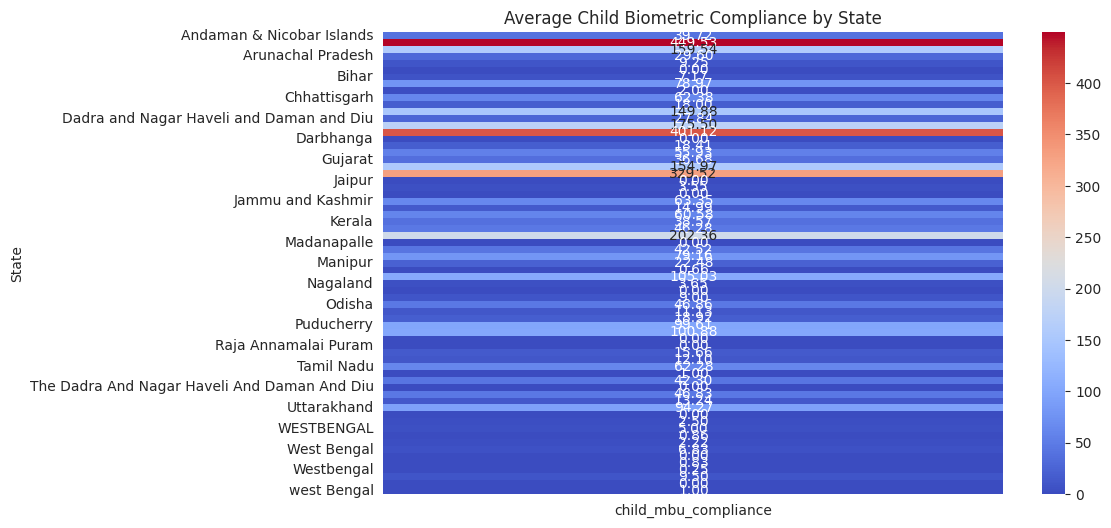

In [ ]:
# ============================================================
# 🎯 Targeted Mobile Biometric Unit (MBU) Campaigns
# ============================================================

# Step 0: Remove 0th row (dummy/corrupted entry)
df_master = df_master.drop(index=0).reset_index(drop=True)

# Step 1: Compute child_mbu_compliance
df_master["child_mbu_compliance"] = df_master["bio_age_5_17"] / (df_master["age_5_17"] + 1)

# Step 2: Define crisis threshold (20th percentile)
crisis_threshold = df_master["child_mbu_compliance"].quantile(0.20)

# Step 3: Flag districts below threshold
mbu_targets = df_master[df_master["child_mbu_compliance"] < crisis_threshold].copy()

# Step 4: Summary
print(f"Districts identified for School Camps: {len(mbu_targets)}")
display(
    mbu_targets[["state", "district", "age_5_17", "bio_age_5_17", "child_mbu_compliance"]]
    .sort_values("child_mbu_compliance")
    .head(5)
)

# ============================================================
# 📊 Visualization
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot: Top 15 lowest compliance districts
plt.figure(figsize=(12,6))
low15 = mbu_targets.sort_values("child_mbu_compliance").head(15)
sns.barplot(
    data=low15,
    x="district",
    y="child_mbu_compliance",
    hue="state",
    dodge=False
)
plt.axhline(crisis_threshold, color="red", linestyle="--", label="20th Percentile Threshold")
plt.title("Lowest Child Biometric Compliance Districts (Age 5–17)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Child MBU Compliance Ratio")
plt.xlabel("District")
plt.legend(title="State")
plt.show()

# Distribution plot: Compliance across all districts
plt.figure(figsize=(10,6))
sns.histplot(df_master["child_mbu_compliance"], bins=30, kde=True, color="skyblue")
plt.axvline(crisis_threshold, color="red", linestyle="--", label="20th Percentile Threshold")
plt.title("Distribution of Child Biometric Compliance Ratios")
plt.xlabel("Child MBU Compliance")
plt.ylabel("Number of Districts")
plt.legend()
plt.show()

# Heatmap: Average compliance by state
plt.figure(figsize=(10,6))
state_avg = df_master.groupby("state")["child_mbu_compliance"].mean().reset_index()
sns.heatmap(
    state_avg.pivot_table(values="child_mbu_compliance", index="state"),
    cmap="coolwarm", annot=True, fmt=".2f"
)
plt.title("Average Child Biometric Compliance by State")
plt.ylabel("State")
plt.show()


Districts flagged for 'Ghost Beneficiary' checks: 1


,state,district,total_enroll,adult_enroll_share
0,100000,100000,218.0,0.990868


/tmp/ipython-input-945747640.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="State")


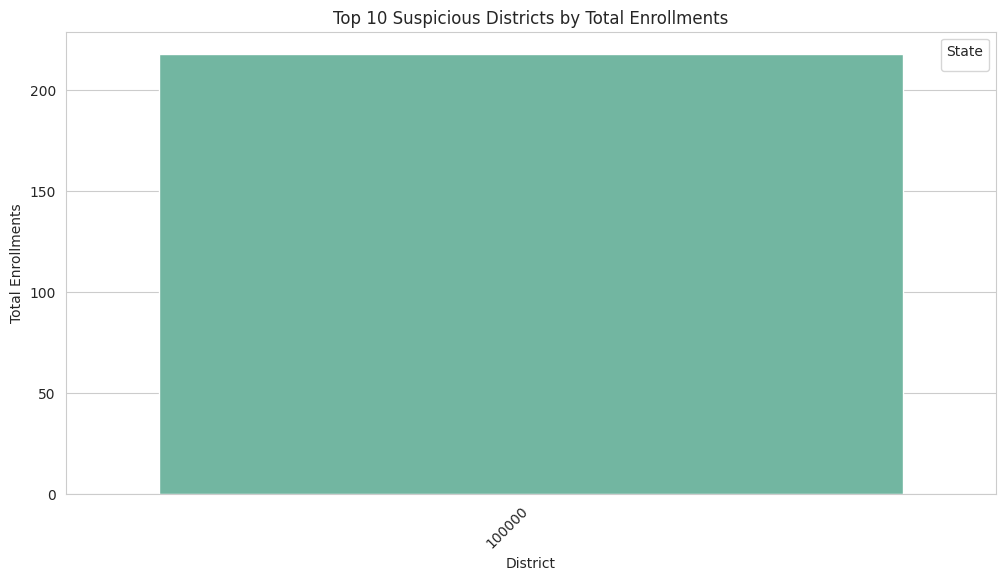

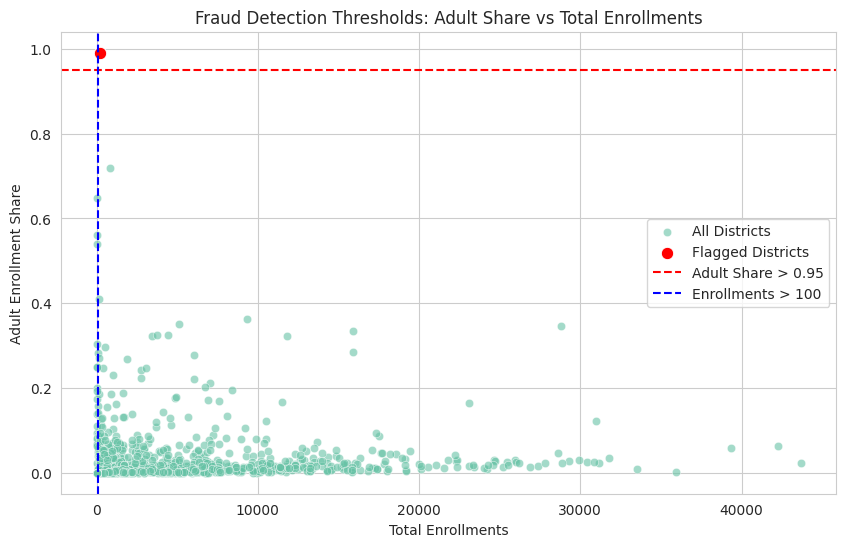

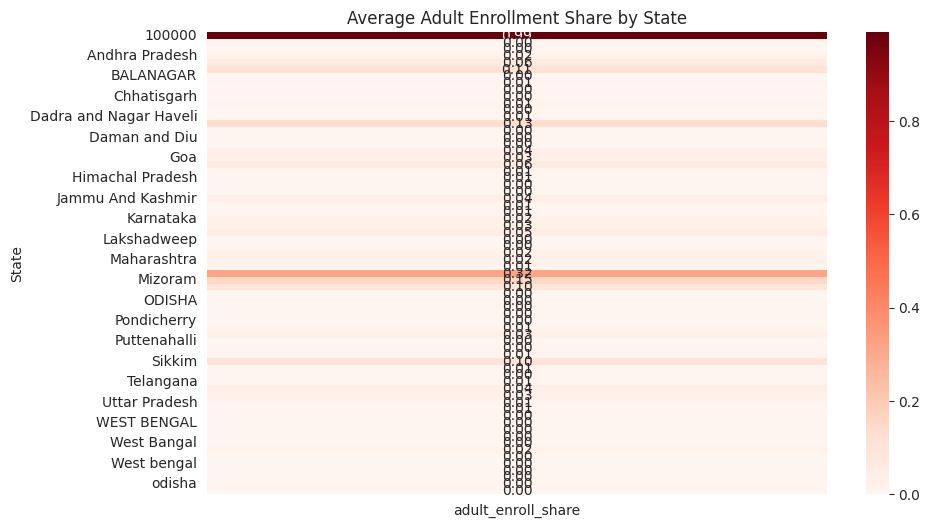

In [ ]:
# ============================================================
# 🔒 Security Audit List for Fraud Detection
# ============================================================

# Step 1: Compute adult enrollment share
df_master["adult_enroll_share"] = df_master["age_18_greater"] / (df_master["total_enroll"] + 1)

# Step 2: Flag suspicious districts
suspicious = df_master[
    (df_master["total_enroll"] > 100) & (df_master["adult_enroll_share"] > 0.95)
].copy()

# Step 3: Summary
print(f"Districts flagged for 'Ghost Beneficiary' checks: {len(suspicious)}")
display(
    suspicious[["state", "district", "total_enroll", "adult_enroll_share"]]
    .sort_values("total_enroll", ascending=False)
    .head(5)
)

# ============================================================
# 📊 Visualization
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot: Top 10 suspicious districts by total enrollments
plt.figure(figsize=(12,6))
top10 = suspicious.sort_values("total_enroll", ascending=False).head(10)
sns.barplot(
    data=top10,
    x="district",
    y="total_enroll",
    hue="state",
    dodge=False
)
plt.title("Top 10 Suspicious Districts by Total Enrollments")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Enrollments")
plt.xlabel("District")
plt.legend(title="State")
plt.show()

# Scatter plot: Adult share vs Total Enrollments
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_master,
    x="total_enroll",
    y="adult_enroll_share",
    alpha=0.6,
    label="All Districts"
)
sns.scatterplot(
    data=suspicious,
    x="total_enroll",
    y="adult_enroll_share",
    color="red",
    s=80,
    label="Flagged Districts"
)
plt.axhline(0.95, color="red", linestyle="--", label="Adult Share > 0.95")
plt.axvline(100, color="blue", linestyle="--", label="Enrollments > 100")
plt.title("Fraud Detection Thresholds: Adult Share vs Total Enrollments")
plt.xlabel("Total Enrollments")
plt.ylabel("Adult Enrollment Share")
plt.legend()
plt.show()

# Heatmap: Average adult enrollment share by state
plt.figure(figsize=(10,6))
state_avg = df_master.groupby("state")["adult_enroll_share"].mean().reset_index()
sns.heatmap(
    state_avg.pivot_table(values="adult_enroll_share", index="state"),
    cmap="Reds", annot=True, fmt=".2f"
)
plt.title("Average Adult Enrollment Share by State")
plt.ylabel("State")
plt.show()


,state,district,demo_age_17_
587,Maharashtra,Thane,411163.0
578,Maharashtra,Pune,405834.0
1110,West Bengal,South 24 Parganas,373409.0
1095,West Bengal,Murshidabad,340843.0
273,Gujarat,Surat,322384.0
1099,West Bengal,North 24 Parganas,275457.0
229,Delhi,North West Delhi,274245.0
410,Karnataka,Bengaluru,265383.0
586,Maharashtra,Solapur,257811.0
1116,West Bengal,Uttar Dinajpur,252655.0


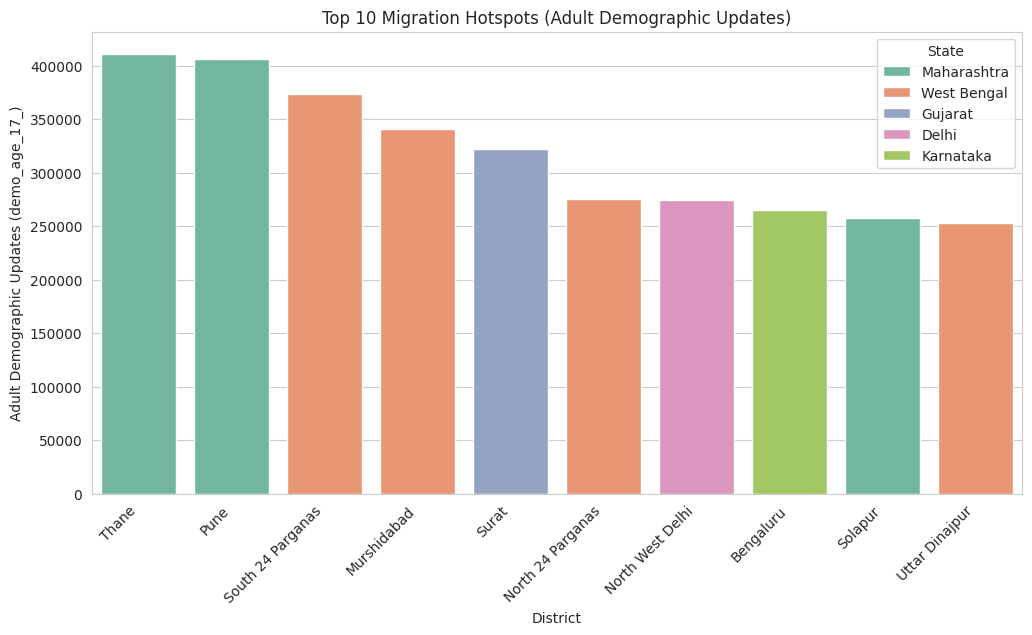

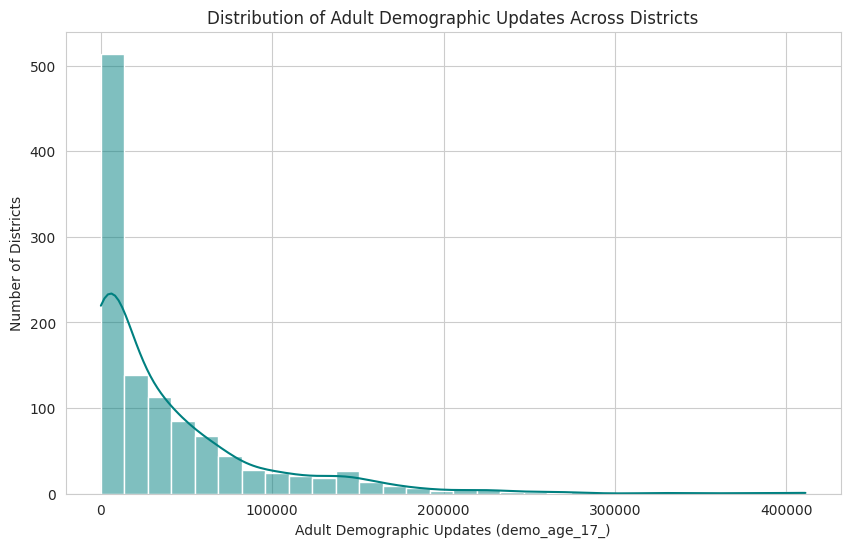

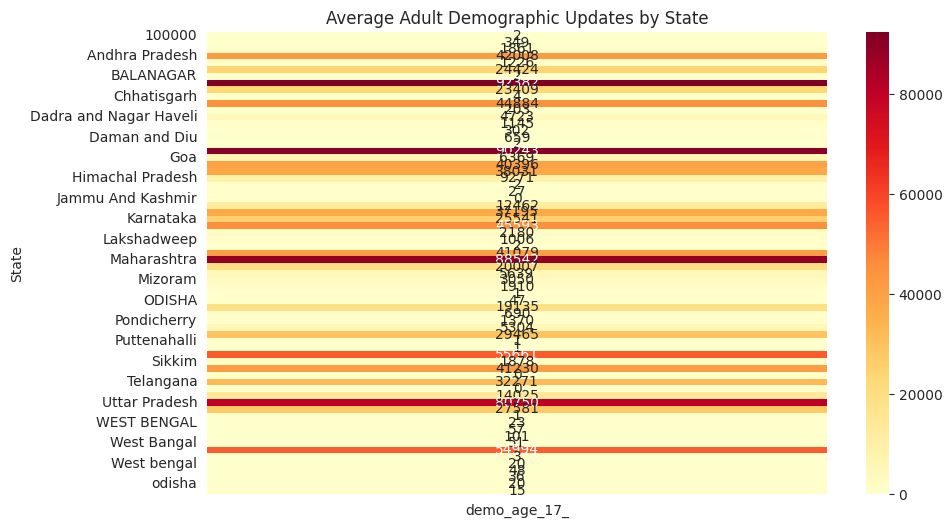

In [ ]:
# ============================================================
# 🚚 Migration Hotspots for Welfare Portability
# ============================================================

# Step 1: Identify top districts by adult demographic updates
migration_hotspots = df_master.sort_values("demo_age_17_", ascending=False).head(10)

# Step 2: Display results
display(migration_hotspots[["state", "district", "demo_age_17_"]])

# ============================================================
# 📊 Visualization
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot: Top 10 migration hotspots
plt.figure(figsize=(12,6))
sns.barplot(
    data=migration_hotspots,
    x="district",
    y="demo_age_17_",
    hue="state",
    dodge=False
)
plt.title("Top 10 Migration Hotspots (Adult Demographic Updates)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Adult Demographic Updates (demo_age_17_)")
plt.xlabel("District")
plt.legend(title="State")
plt.show()

# Distribution plot: Adult demographic updates across all districts
plt.figure(figsize=(10,6))
sns.histplot(df_master["demo_age_17_"], bins=30, kde=True, color="teal")
plt.title("Distribution of Adult Demographic Updates Across Districts")
plt.xlabel("Adult Demographic Updates (demo_age_17_)")
plt.ylabel("Number of Districts")
plt.show()

# Heatmap: Average adult demographic updates by state
plt.figure(figsize=(10,6))
state_avg = df_master.groupby("state")["demo_age_17_"].mean().reset_index()
sns.heatmap(
    state_avg.pivot_table(values="demo_age_17_", index="state"),
    cmap="YlOrRd", annot=True, fmt=".0f"
)
plt.title("Average Adult Demographic Updates by State")
plt.ylabel("State")
plt.show()
